# Competition: Pump it Up: Data Mining the Water Table

##### Can you predict which water pumps are faulty to promote access to clean, potable water across Tanzania? This is an intermediate-level practice competition.

##### Your goal is to predict the operating condition of a waterpoint for each record in the dataset

Nos hemos registrado en la página de _Driven Data_ y unido a la competición.

Podemos acceder a la definición de cada uno de los campos en el siguiente link: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

Finalmente, una vez realizado todo el proceso, generamos los resultados y los subimosen el siguiente link: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/submissions/

Se pueden subir un total de 3 intentos al día y nos indica en cada uno de ellos la métrica de aciertos (precisión) y nuestra posición entre todos los participantes. Finalmente se queda con el mejor score de todas las pruebas que intentemos.


## Descripción del Notebook

En este notebook, realizaremos un preprocesado completo, analizando cada variable tanto desde un punto de vista analítico como funcional. El objetivo es entender la naturaleza de cada dato y cómo se relaciona con el resto del conjunto de datos.

Una vez completado el preprocesado, probaremos diferentes modelos de machine learning, aprovechando la experiencia previa adquirida en intentos anteriores y el conocimiento del conjunto de datos con el que estamos trabajando. Esto nos permitirá enfocarnos en las variables que consideramos más relevantes y otorgarles mayor atención en el proceso.

Aunque no todas las ideas han sido exitosas a nivel de resultado, hemos decidido incluir algunas que nos parecieron interesantes para que queden comentadas dentro del notebook.


# 0. Importación de librerías y lectura del fichero

Importamos las librerías necesarias para el ejercicio.


In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import missingno as msno  

from datetime import datetime
import requests
import seaborn as sns
sns.set()

# Configurar el backend de matplotlib para Jupyter Notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import re

# IQR/Z score.
from scipy.stats import stats

# Selección de variables.
from sklearn.feature_selection import SelectKBest

# Imputación de variables.
import sklearn.impute as skl_imp

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.cluster import KMeans

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
import pickle

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

C:\Users\abr28\AppData\Local\Temp\ipykernel_19656\2631184209.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Leemos el fichero y obtenemos un primer resumen de los datos con los que vamos a trabajar. Convertimos la columna id en el índice de nuestro DataFrame, ya que no tiene una función relevante dentro del análisis.


In [2]:
# Lectura del fichero de entrenamiento
x_train_orig = pd.read_csv('input/training_set_values.csv')
x_train_orig.set_index('id', inplace=True) # Guardar la columna 'id' como índice

# Lectura del fichero a predecir
x_test_orig = pd.read_csv('input/test_set_values.csv')
x_test_orig.set_index('id', inplace=True) # Guardar la columna 'id' como índice

# Mostrar todas las columnas
pd.options.display.max_columns = None

dataframe = pd.concat([x_train_orig, x_test_orig])
dataframe.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


En este paso, estamos combinando tanto el fichero de entrenamiento como los nuevos datos que vamos a predecir posteriormente. Tomamos esta decisión para simplificar el proceso de preprocesamiento de los nuevos datos, ya que, de lo contrario, nos resultaba muy complicado y engorroso imputar con la misma moda y asegurar la consistencia del preprocesamiento (sobre todo para técnicas como KNN). Esta metodología garantiza que las transformaciones aplicadas sean uniformes en ambos conjuntos de datos, lo que es especialmente útil cuando se utilizan técnicas como KNN para la imputación de valores faltantes. En este caso particular, trabajar con un número reducido de registros en el conjunto de test podría generar valores atípicos o inconsistencias por lo que entendemos esto como una ventaja.

Aunque soy consciente de que esta metodología podría introducir cierto sobreajuste en el modelo a la hora de imputar (ya que en el entrenamiento del modelo lógicamente no se tendrán en cuenta los nuevos datos), considero que existe cierto beneficio de contar con un conjunto de datos más grande para imputaciones. Sin embargo, es importante señalar que este enfoque podría llevar a un menor grado en su capacidad para generalizar a nuevos datos.

Dicho esto, entiendo ambos puntos de vista y me gustaría contar con más puntos de vista en cuál es la mejor opción y por qué. Por ahora, continuaremos con el preprocesado en bloque.


## 1. Análisis exploratorio de las variables


Observamos un resumen a nivel formato e información sobre todas las variables de dataset.


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 69572 to 68707
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   date_recorded          74250 non-null  object 
 2   funder                 69743 non-null  object 
 3   gps_height             74250 non-null  int64  
 4   installer              69718 non-null  object 
 5   longitude              74250 non-null  float64
 6   latitude               74250 non-null  float64
 7   wpt_name               74248 non-null  object 
 8   num_private            74250 non-null  int64  
 9   basin                  74250 non-null  object 
 10  subvillage             73780 non-null  object 
 11  region                 74250 non-null  object 
 12  region_code            74250 non-null  int64  
 13  district_code          74250 non-null  int64  
 14  lga                    74250 non-null  object 
 15  war

Nos exportamos en un fichero _html_ el resumen de los datos con los que vamos a trabajar. Podemos observar la distintas distribuciones y análisis de missings o outliers.


Visualizamos la matriz de correlaciones de las variables numéricas.


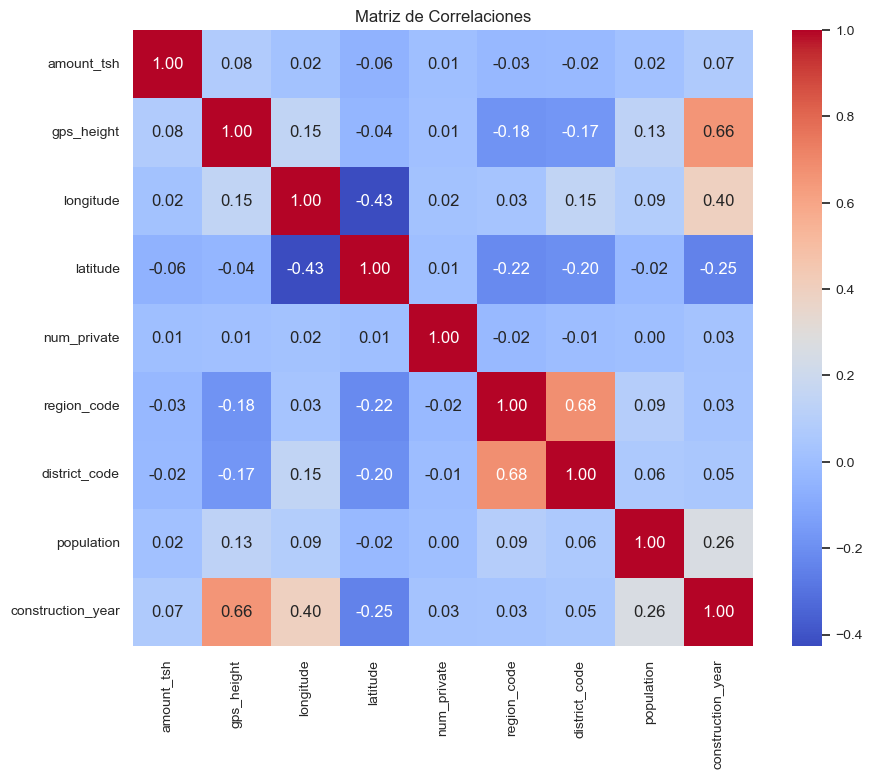

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(dataframe.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlaciones')
plt.show()

Observamos que las variables _latitud - longitud_ y _district code - region code_ parecen estar altamente correlacionadas, lo cual es lógico dado que ambas describen ubicaciones geográficas similares.

Asimismo, encontramos una correlación entre _latitud/longitud_ y _construction year_. Esto puede explicarse por el hecho de que en un año determinado se instalan cañerías en una misma región o barrio.

De manera similar, esta relación nos ayuda a entender la correlación entre _gps_height_ (altitud del pozo) y _construction year_, ya que la construcción en áreas con características geográficas similares podría ocurrir en un mismo período.


Revisamos además, las agrupaciones de los valores de cada uno de los campos de nuestro dataframe.


In [5]:
for i in dataframe.columns:
    print(dataframe[i].value_counts())
    print('\n')

amount_tsh
0.0         52049
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
250000.0        1
350000.0        1
5400.0          1
53.0            1
0.5             1
Name: count, Length: 102, dtype: int64


date_recorded
2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-01      1
2011-09-28      1
2011-09-16      1
2011-09-13      1
2004-01-09      1
Name: count, Length: 369, dtype: int64


funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
                          ...  
Sido                          1
Mosqure                       1
Kkkt Canal                    1
Rc Missionary                 1
Velem                         1
Name: count, Length: 2139, dtype: int64


gps_height
 0       25649
-16         71
-15         69
-13         68
-19         65
         .

quality_group
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: count, dtype: int64


quantity
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


quantity_group
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


source
spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: count, dtype: int64


source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                  

### Resumen de las variables numéricas


In [6]:
dataframe.select_dtypes(include=[np.number]).describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Mostramos la distribución de cada una de las variables numéricas.


C:\Users\abr28\AppData\Local\Temp\ipykernel_19656\3010744628.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, bins=20, ax=axs[index])
C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\abr28\AppData\Local\Temp\ipykernel_19656\3010744628.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simi

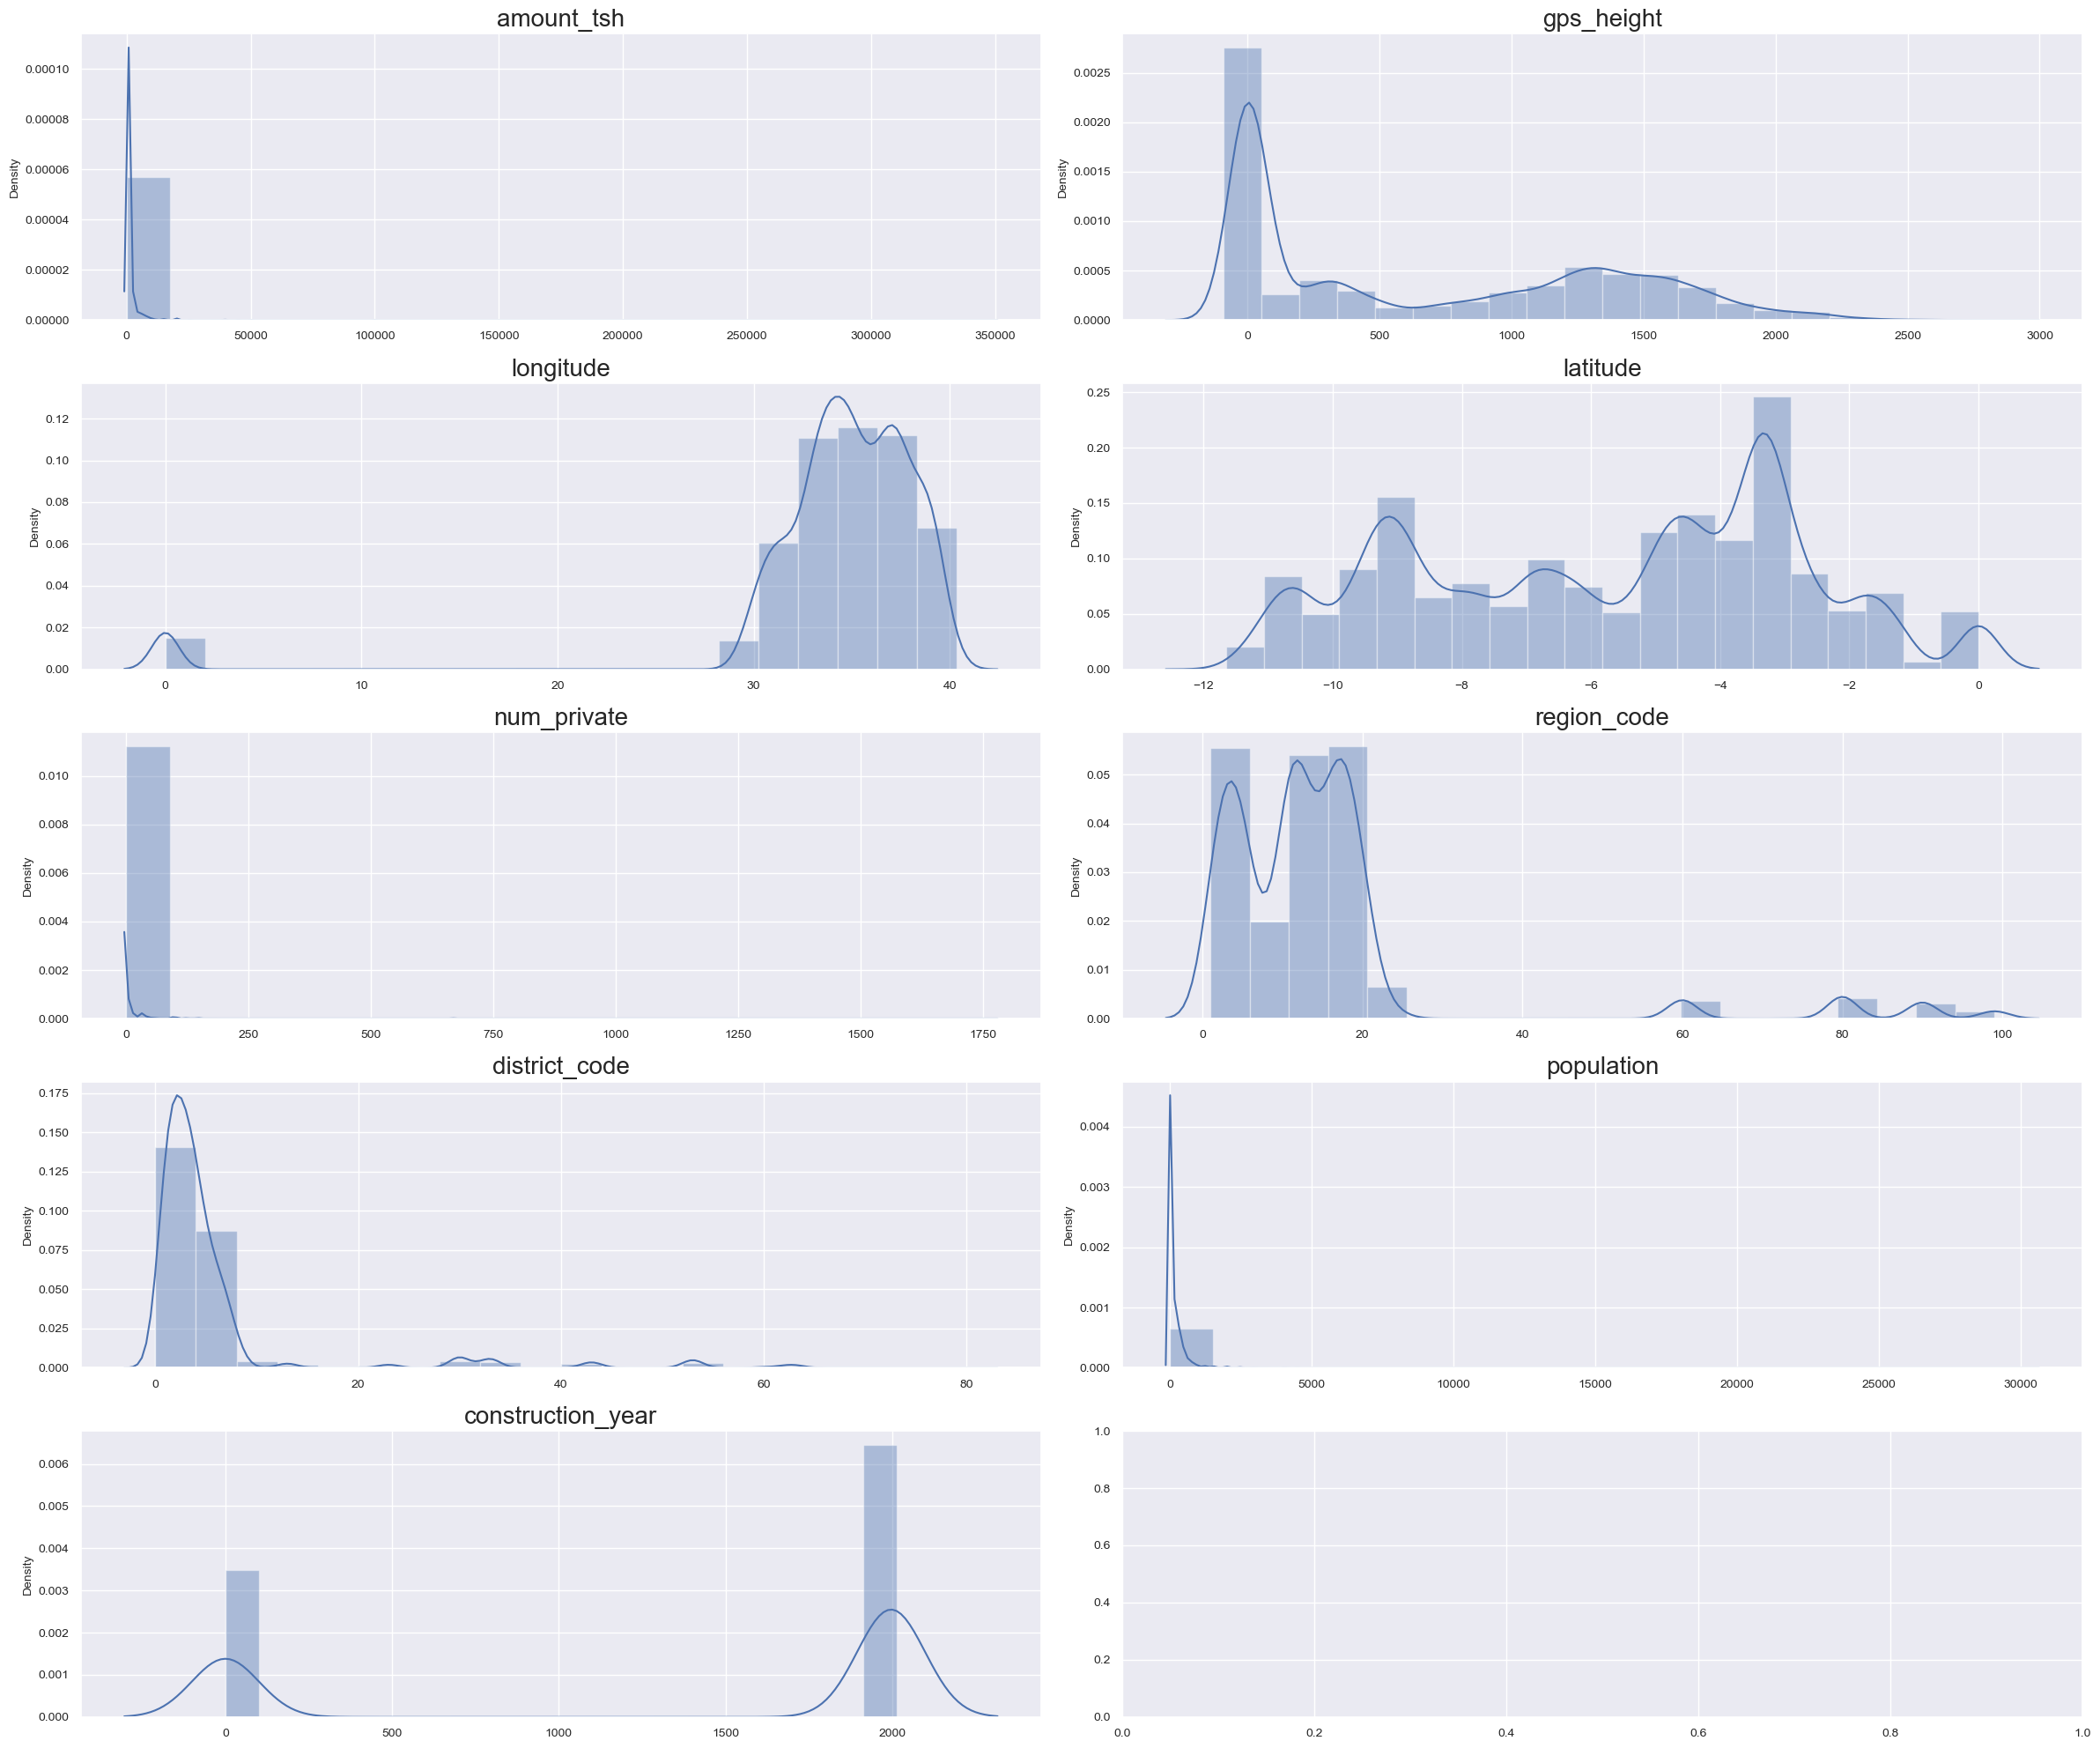

In [7]:
#Variables numéricas
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(24, 20))
axs = axs.flatten() 

index = 0
for k,v in dataframe.select_dtypes(include=[np.number]).items(): 
    if  (k == 'permanencia'):
        sns.countplot(v, ax=axs[index])
    else:
        sns.distplot(v, bins=20, ax=axs[index])
        
    axs[index].set_title(k, fontsize=20)  # Ajustar el tamaño de la fuente del título
    axs[index].set_xlabel('')  # Eliminar el nombre de la variable en el eje x
    index += 1

plt.tight_layout() # Para ajustar el espacio entre subplots
plt.show()

Observamos la existencia de ciertas variables con una distribución muy asimétrica o una concentración de valores muy centrada alrededor de ciertos valores concretos, normalmente el 0 (por ejemplo, _gps_height_ o _construction_year_).


### Resumen de las variables categóricas


In [8]:
# Mostrar todas las columnas
pd.options.display.max_columns = None

dataframe.select_dtypes(include=['object','category']).describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69743,69718,74248,74250,73780,74250,74250,74250,70095,74250,69403,38198,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2139,2410,45683,9,21425,21,125,2098,2,1,11,2867,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,74250,45917,858,48606,33263,33263,33263,50624,65538,31712,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


Para las variables categóricas deberemos realizar un tratamiento previo ya que muchas de ellas tienen un número demasiado grande de valores únicos. Más adelante, intentaremos agrupar los distintos valores de forma que tengamos un número manejable de categorías para poder construir el modelo (en principio, alrededor de 10 valores únicos).


## 2. Preprocesado y limpieza de los datos


### 2.1. Análisis de missings (valores nulos)

Mostramos el porcentaje de valores no informados por variable.


In [9]:
dataframe.apply(lambda x: x.isna().sum()/dataframe.shape[0]*100)

amount_tsh                0.000000
date_recorded             0.000000
funder                    6.070034
gps_height                0.000000
installer                 6.103704
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.002694
num_private               0.000000
basin                     0.000000
subvillage                0.632997
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.595960
recorded_by               0.000000
scheme_management         6.527946
scheme_name              48.554882
permit                    5.108418
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment             

Identificamos nulos en los siguientes campos:

- funder (who funded the well): 6'07%.
- installer (organization that installed the well): 6'10%.
- wpt_name (name of the waterpoint if there is one): 0'003%.
- subvillage (geographic location): 0'63%.
- public_meeting (True/False): 5'60%.
- scheme_management (who operates the waterpoint): 6'53%.
- scheme_name (Who operates the waterpoint): 48'55% **(!!!)**.
- permit (if the waterpoint is permitted): 5'11%.

Observamos que la variable **scheme_name** presenta un 48'55% de missings en todo nuestro dataset. Esto nos hace dudar sobre si mantener esta variable dentro de nuestro modelo ya que imputarla podría llegar a desvirtuar la muestra en cualquiera de sus formas, son demasiados registros sin informar.

Mostramos también la distribución de los missings en todos los registros para entender cuales son los registros con más missings y además poder identificar si existiera alguna correlación entre los valores no informados entre variables.


prop_missings
0    33965
1    28269
2     7019
3     4060
4      823
5      105
6        9
Name: count, dtype: int64

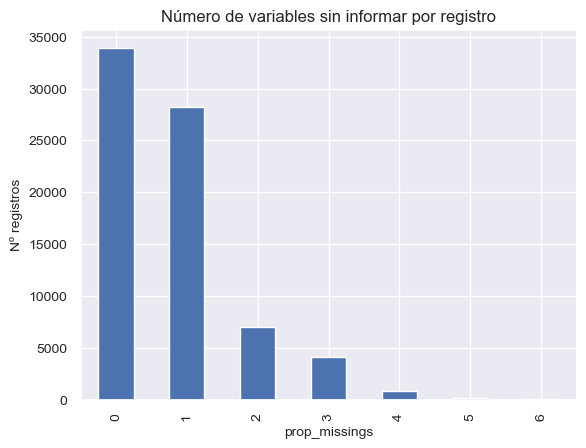

In [10]:
dataframe['prop_missings'] = dataframe.apply(lambda x: x.isna().sum(),axis=1)
display(dataframe['prop_missings'].value_counts())

# Histograma
dataframe['prop_missings'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('prop_missings')
plt.ylabel('Nº registros')
plt.title('Número de variables sin informar por registro')

plt.show()

El número máximo de variables sin informar es 6. Sin embargo, sí que vemos que gran parte de la muestra tiene al menos una variable sin informar. Entendemos que se debe en gran parte a la variable **_scheme_name_**, por tanto, eliminamos esta variable ya que no consideramos que merezca la pena imputarla y más, teniendo en cuenta que su significado no parece del todo útil para el modelo y que al tener tantas granularidad nos puede provocar _overfitting_.


prop_missings
0    60382
1     8735
3     2844
2     2063
4      217
5        9
Name: count, dtype: int64

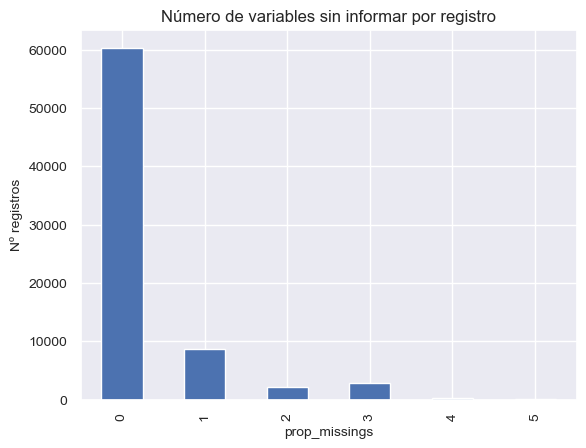

In [11]:
dataframe_analisis = dataframe.copy()

dataframe_analisis.drop('scheme_name', axis=1, inplace=True)

dataframe_analisis['prop_missings'] = dataframe_analisis.apply(lambda x: x.isna().sum(),axis=1)
display(dataframe_analisis['prop_missings'].value_counts())

# Histograma
dataframe_analisis['prop_missings'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('prop_missings')
plt.ylabel('Nº registros')
plt.title('Número de variables sin informar por registro')

plt.show()

# Eliminamos la columna 'recorded_by'
dataframe_analisis = dataframe_analisis.drop(columns=['prop_missings'])

### 2.2. Análisis individual de las variables

Recordamos que tenemos las siguientes valores con alguno de sus registros con missings: **funder, installer, wpt_name, subvillage, public_meeting, scheme_management, scheme_name, permit**.

Además y, tal y como hemos comentado, miraremos en más detalle las variables **gps_height** y **construction_year** y otras variables cuya distribución nos genera dudas.


In [12]:
# Trabajamos desde otro dataframe
dataframe_select = dataframe_analisis.copy()

**recorded_by**: toma siempre el mismo valor y no tiene ningún tipo de importancia para nuestro análisis. Eliminamos este campo.


In [13]:
# Eliminamos la columna 'recorded_by'
dataframe_select = dataframe_select.drop(columns=['recorded_by'])

### Pares de variables con misma información

Encontramos varios pares de variables que parecen tener, a priori, la misma información por lo que analizaremos su significado y el valor que aporta cada una de ellas o, si fuera posible, prescindir de una de los pares de variables.

**scheme_management - scheme_name**: estas parecen variables con un número mayor de clases cada una de ellas. Dado que _scheme_name_ se encontraba con casi la mitad de registros sin informar, decidimos eliminar esa variable.

Sin embargo, la variable **scheme_management** recordamos que tiene varios registros sin valor informado, por lo que la imputaremos mediante la moda.


In [14]:
# Imputamos variables por moda.
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

# Imputamos la columna 'scheme_management' y la actualizamos en el DataFrame
dataframe_select['scheme_management'] = imputer_moda.fit_transform(dataframe_select[['scheme_management']]).ravel()
dataframe_select.index = dataframe_select.index # Mantenemos el índice original

# Comprobar la información del DataFrame
dataframe_select['scheme_management'].describe()

count     74250
unique       11
top         VWC
freq      50764
Name: scheme_management, dtype: object

**extraction_type_class - extraction_type_group - extraction_type**: parece que, al menos por los nombres, estas variables recogen la misma información pero con diferente grado de granularidad. Las revisamos:


In [15]:
# Observamos la naturaleza de estos 3 campos.
grouped_counts = dataframe_select.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type']).size().reset_index(name='counts')
grouped_counts

,extraction_type_class,extraction_type_group,extraction_type,counts
0,gravity,gravity,gravity,33263
1,handpump,afridev,afridev,2208
2,handpump,india mark ii,india mark ii,3029
3,handpump,india mark iii,india mark iii,135
4,handpump,nira/tanira,nira/tanira,10205
5,handpump,other handpump,other - mkulima/shinyanga,2
6,handpump,other handpump,other - play pump,101
7,handpump,other handpump,other - swn 81,284
8,handpump,other handpump,walimi,60
9,handpump,swn 80,swn 80,4588


Vamos a mantener todas estas variables pero tratando de reducir su cardinalidad a 10 clases cada una. En particular, **extraction_type** y **extraction_type_group** recogen la misma información por lo que nos quedaremos únicamente con la variable más agrupada y modificaremos alguno de sus valores con el fin de reducir los valores únicos.


In [16]:
# Parametrizamos de nuevo la columna 'extraction_type_group'
dataframe_select['extraction_type_group'] = dataframe_select['extraction_type_group'].replace({
#     'other - swn 81': 'swn', # La cambiamos más adelante.
    'swn 80': 'swn',
    'india mark ii': 'india mark',
    'india mark iii': 'india mark'
})

dataframe_select.loc[(dataframe_select['extraction_type_group'] == 'other handpump') & 
         (dataframe_select['extraction_type'] == 'other - swn 81'), 'extraction_type_group'] = 'swn'


# Eliminamos la columna 'extraction_type_group'
dataframe_select = dataframe_select.drop(columns=['extraction_type'])

# Comprobamos los resultados tras la parametrización
grouped_counts = dataframe_select.groupby(['extraction_type_class', 'extraction_type_group']).size().reset_index(name='counts')
grouped_counts

,extraction_type_class,extraction_type_group,counts
0,gravity,gravity,33263
1,handpump,afridev,2208
2,handpump,india mark,3164
3,handpump,nira/tanira,10205
4,handpump,other handpump,163
5,handpump,swn,4872
6,motorpump,mono,3628
7,motorpump,other motorpump,149
8,other,other,8102
9,rope pump,rope pump,572


Nos quedamos finalmente con 12 clases lo cual nos parece un número aceptable para el posterior modelo. Hemos eliminado la variable _extraction_type_.


**management - management_group**: al igual que antes parece que estas variables recogen la misma información pero con diferente grado de granularidad. Estudiamos su naturaleza.


In [17]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['management', 'management_group']).size().reset_index(name='counts')
grouped_counts

,management,management_group,counts
0,company,commercial,859
1,other,other,1083
2,other - school,other,126
3,parastatal,parastatal,2229
4,private operator,commercial,2504
5,trust,commercial,105
6,unknown,unknown,683
7,vwc,user-group,50624
8,water authority,commercial,1123
9,water board,user-group,3688


No nos parece un número excesivo de clases, _management_ es la más aperturada con 12 categorías distintas. Mantenemos de momento ambas variables ya que no vemos que sea exactamente la misma información.


**payment - payment_type**: al igual que antes parece que estas variables recogen la misma información pero con diferente grado de granularidad, las observamos.


In [18]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['payment', 'payment_type']).size().reset_index(name='counts')
grouped_counts

,payment,payment_type,counts
0,never pay,never pay,31712
1,other,other,1314
2,pay annually,annually,4570
3,pay monthly,monthly,10397
4,pay per bucket,per bucket,11266
5,pay when scheme fails,on failure,4842
6,unknown,unknown,10149


Ambas variables contienen exactamente la misma información por lo que nos quedamos únicamente con _payment_type_.


In [19]:
# Eliminamos la columna 'payment'
dataframe_select = dataframe_select.drop(columns=['payment'])

**water_quality - quality_group**: estudiamos la naturaleza de ambas variables.


In [20]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['water_quality', 'quality_group']).size().reset_index(name='counts')
grouped_counts

,water_quality,quality_group,counts
0,coloured,colored,623
1,fluoride,fluoride,244
2,fluoride abandoned,fluoride,23
3,milky,milky,1005
4,salty,salty,6082
5,salty abandoned,salty,423
6,soft,good,63505
7,unknown,unknown,2345


Ambas variables se refieren a la calidad del agua, nos quedamos únicamente con la variable _water_quality_ ya que la información es más precisa y un número razonable de clases. Eliminamos _quality_group_.


In [21]:
# Eliminamos la columna 'quality_group'
dataframe_select = dataframe_select.drop(columns=['quality_group'])

**quantity - quantity_group**: estudiamos la naturaleza de ambas variables.


In [22]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['quantity', 'quantity_group']).size().reset_index(name='counts')
grouped_counts

,quantity,quantity_group,counts
0,dry,dry,7782
1,enough,enough,41522
2,insufficient,insufficient,18896
3,seasonal,seasonal,5075
4,unknown,unknown,975


Contienen exactamente la misma información, eliminamos una de ellas (_quantity_group_).


In [23]:
# Eliminamos la columna 'quantity_group'
dataframe_select = dataframe_select.drop(columns=['quantity_group'])

**source - source_type - source_class**: estudiamos la naturaleza de las variables.


In [24]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['source', 'source_type', 'source_class']).size().reset_index(name='counts')
grouped_counts

,source,source_type,source_class,counts
0,dam,dam,surface,840
1,hand dtw,borehole,groundwater,1108
2,lake,river/lake,surface,950
3,machine dbh,borehole,groundwater,13822
4,other,other,unknown,261
5,rainwater harvesting,rainwater harvesting,surface,2863
6,river,river/lake,surface,11964
7,shallow well,shallow well,groundwater,21140
8,spring,spring,groundwater,21216
9,unknown,other,unknown,86


Observamos que la variable _source_ y _source_type_ son muestran prácticamente la misma información por lo que eliminamos _source_type_. Observamos también que el valor "other" podría referirse a desconocido, por lo que la renombramos y de esta forma agrupamos esa clase.


In [25]:
# Eliminamos la columna 'source_type'
dataframe_select = dataframe_select.drop(columns=['source_type'])

# Parametrizamos de nuevo la columna 'extraction_type_group'
dataframe_select['source'] = dataframe_select['source'].replace({'other': 'unknown'})
grouped_counts = dataframe_select.groupby(['source', 'source_class']).size().reset_index(name='counts')
grouped_counts

,source,source_class,counts
0,dam,surface,840
1,hand dtw,groundwater,1108
2,lake,surface,950
3,machine dbh,groundwater,13822
4,rainwater harvesting,surface,2863
5,river,surface,11964
6,shallow well,groundwater,21140
7,spring,groundwater,21216
8,unknown,unknown,347


**waterpoint_type - waterpoint_type_group**: estudiamos la naturaleza de las variables.


In [26]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['waterpoint_type', 'waterpoint_type_group']).size().reset_index(name='counts')
grouped_counts

,waterpoint_type,waterpoint_type_group,counts
0,cattle trough,cattle trough,150
1,communal standpipe,communal standpipe,35628
2,communal standpipe multiple,communal standpipe,7611
3,dam,dam,8
4,hand pump,hand pump,21884
5,improved spring,improved spring,959
6,other,other,8010


Contienen exactamente la misma información, eliminamos _waterpoint_type_group_.


In [27]:
# Eliminamos la columna 'waterpoint_type_group'
dataframe_select = dataframe_select.drop(columns=['waterpoint_type_group'])

### Variables que informan sobre la localización de las bombas de agua

Tenemos varios campos que nos aportan información similar sobre la localización geográfica de las bombas de agua. Estas variables son: **basin, region, region_code, district_code, ward, subvillage, lga, longitude** y **latitude**. Las estudiamos y analizamos.

Además, vamos a tener en cuenta dentro de este grupo a la variable **gps_height** (altitude of the well), característica que puede depender de la propia localización de la bomba de agua.


In [28]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['region', 'region_code', 'district_code']).size().reset_index(name='counts')
grouped_counts

,region,region_code,district_code,counts
0,Arusha,2,1,226
1,Arusha,2,2,1460
2,Arusha,2,3,143
3,Arusha,2,5,245
4,Arusha,2,6,391
...,...,...,...,...
133,Tanga,4,5,361
134,Tanga,4,6,341
135,Tanga,4,7,170
136,Tanga,4,8,347


Observamos que una _region_ (o _region_code_) puede tener varios _district_code_, por lo entendemos que este último campo indica un distrito concreto de cada una de las regiones. Igualmente, vemos que un _district_code_ puede estar presente en distintas _region_ (o _region_code_).


In [29]:
grouped_counts = dataframe_select.groupby(['region', 'region_code']).size().reset_index(name='counts').sort_values(by='region_code')
grouped_counts

,region,region_code,counts
3,Dodoma,1,2779
0,Arusha,2,3709
7,Kilimanjaro,3,5494
31,Tanga,4,3145
14,Morogoro,5,5038
32,Tanga,5,41
21,Pwani,6,2032
2,Dar es Salaam,7,1020
8,Lindi,8,375
15,Mtwara,9,499


De la misma forma, observamos que la variable _region_code_ no es única para cada una de las _region_ (por ejemplo _region_code_ = 5), ni viceversa (por ejemplo _region_ = Tanga), es decir, estas dos variables no tienen una relación directa unívoca.

Apoyándonos en el .describe() que mostramos antes, vemos por el número de clases cuales de estas variables nos aportan mayor o menor detalle respecto a la localización geográfica. De menor a mayor granularidad sería: _region/region_code - district_code - ward - subvillage - longitude/latitude_.

Como ya hemos visto en otras pruebas que hemos realizado y en la distribución de las variables, nos damos cuenta de que hay varios registros con _longitude_ y _latitude_ igual a (0, 0). Pese a que no son "missings" como tal, buscamos en Internet que las coordenadas entre las que se encuentra Tanzania para _longitude_ y _latitude_ son 29-40 y 1-12 respectivamente. Por tanto, las trataremos como missings y las imputaremos apoyándonos en la media de estas variables según la _region_ - *district_code\*\* a la que pertenezcan (el campo *region* no tiene missings), en caso de no encontrar esa combinación para poder imputar, asignaremos la media a nivel de *region\* únicamente.


In [30]:
# 1. PASAMOS A MISSINGS LOS VALORES NO VÁLIDOS PARA LONGITUDE Y LATITUDE
# Reemplazar valores 0 por NaN en la columna 'longitude'
dataframe_select['longitude'] = dataframe_select['longitude'].replace(0, np.nan)
print('Valores no válidos para la variable LONGITUDE:', dataframe_select['longitude'].isna().sum())

# Reemplazar valores 0 por NaN en la columna 'latitude'
dataframe_select['latitude'] = dataframe_select['latitude'].replace(-2.000000e-08, np.nan)
print('Valores no válidos para la variable LATITUDE:', dataframe_select['latitude'].isna().sum())


# 2. CALCULAMOS LAS MEDIAS A NIVEL REGION - DISTRITO
# Calcular promedios en distritos dentro de regiones
dataframe_select['district_longitude'] = dataframe_select.groupby(['region', 'district_code'])['longitude'].transform(lambda x: x.mean(skipna=True))
dataframe_select['district_latitude'] = dataframe_select.groupby(['region', 'district_code'])['latitude'].transform(lambda x: x.mean(skipna=True))

# Calcular promedios en regiones
# En caso de que los promedios a imputar no tenga la combinación Region - District_Code informada, lo informaremos únicamente a nivel region
dataframe_select['region_longitude'] = dataframe_select.groupby('region')['longitude'].transform(lambda x: x.mean(skipna=True))
dataframe_select['region_latitude'] = dataframe_select.groupby('region')['latitude'].transform(lambda x: x.mean(skipna=True))


# 3. IMPUTAMOS VALORES
# "Imputar" valores faltantes de longitud/latitud
dataframe_select['longitude'] = np.where(dataframe_select['longitude'].notna(), dataframe_select['longitude'],
                             np.where(dataframe_select['district_longitude'].notna(), dataframe_select['district_longitude'], dataframe_select['region_longitude']))

dataframe_select['latitude'] = np.where(dataframe_select['latitude'].notna(), dataframe_select['latitude'],
                            np.where(dataframe_select['district_latitude'].notna(), dataframe_select['district_latitude'], dataframe_select['region_latitude']))

# Eliminamos la columnas auxiliares
dataframe_select = dataframe_select.drop(columns=['district_longitude','district_latitude', 'region_longitude', 'region_latitude'])


# 4. COMPROBACIÓN
# Observamos que efectivamente, se ha producido el cambio correctamente (miramos valores mínimos y máximos).
dataframe_select[['longitude', 'latitude']].describe()

Valores no válidos para la variable LONGITUDE: 2269
Valores no válidos para la variable LATITUDE: 2269


,longitude,latitude
count,74250.000000,74250.000000
mean,35.104994,-5.787021
std,2.581922,2.816543
min,29.607122,-11.649440
25%,33.263917,-8.525675
50%,34.907475,-5.026540
75%,37.181685,-3.325170
max,40.345193,-0.998464


Mantenemos la variable _region_ que tiene un número de clases discutible (21 valores únicos) pero asequible para el modelo y las variables _longitude_ y _latitude_.


Analizamos de forma más detenida la variable **lga** ya que en la primera agrupación de valores que vimos al inicio del notebook parecía indicarnos junto al nombre de la región si esta misma era "rural" o "urbana" en algunos de los casos, quizás esta información pueda ser valiosa.


In [31]:
# Comprobamos los resultados
grouped_counts = dataframe_select.groupby(['lga']).size().reset_index(name='counts')
grouped_counts

,lga,counts
0,Arusha Rural,1521
1,Arusha Urban,82
2,Babati,618
3,Bagamoyo,1263
4,Bahi,279
...,...,...
120,Tunduru,539
121,Ukerewe,442
122,Ulanga,841
123,Urambo,489


No todos los registros tienen indicado si es urbana o rural por lo que lo dividiremos en las siguientes 3 clases: rural, urbana, other. Esta puede ser una variable interesante respecto al mantenimiento de las bombas de agua en cada una de estas zonas.


In [32]:
# Reparametrizamos la variable "lga"
dataframe_select['lga'] = np.where(dataframe_select['lga'].str.contains(" Rural"), "rural",
                       np.where(dataframe_select['lga'].str.contains(" Urban"), "urban", "other"))

# Comprobamos los resultados
grouped_counts = dataframe_select.groupby(['lga']).size().reset_index(name='counts')
grouped_counts

,lga,counts
0,other,60318
1,rural,11814
2,urban,2118


La variable **basin** se refiere a la cuenca hidrográfica geográfica de la cual proviene el agua de la que se alimenta la tubería. Observamos su naturaleza, ¿podría darse que un tipo de agua (salinidad, mirenalidad, control de calidad...) pudeieran ser más nocivas para el mantenimiento o durabilidad de una bomba de agua? Dado su número reducido de clases y que parece estar bien informada, mantenemos la variable.


In [33]:
# Observamos la naturaleza de estos campos.
grouped_counts = dataframe_select.groupby(['basin']).size().reset_index(name='counts')
grouped_counts

,basin,counts
0,Internal,9642
1,Lake Nyasa,6332
2,Lake Rukwa,3059
3,Lake Tanganyika,8052
4,Lake Victoria,12871
5,Pangani,11143
6,Rufiji,9987
7,Ruvuma / Southern Coast,5587
8,Wami / Ruvu,7577


**gps_height**: vamos a analizar esta variable más detenidamente. Vimos en la agrupación por valores que podía estar muy sesgada hacia la izquierda al tomar muchos valores igual a 0.


gps_height
 0       25649
-16         71
-15         69
-13         68
-19         65
         ...  
 2407        1
 2291        1
 2322        1
 2251        1
 2265        1
Name: count, Length: 2456, dtype: int64

C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


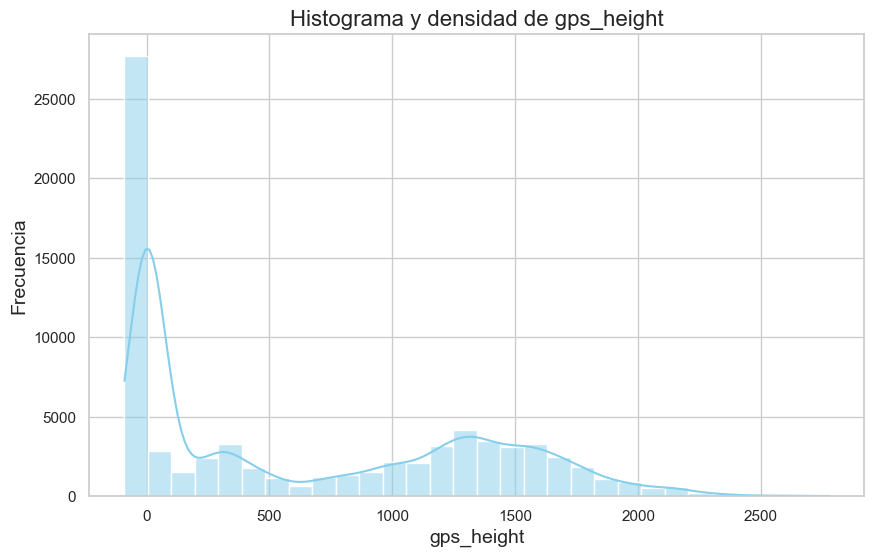

In [34]:
# Agrupación para ver los valores
display(dataframe_select['gps_height'].value_counts())

# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico con histograma y densidad
plt.figure(figsize=(10, 6))
sns.histplot(dataframe_select['gps_height'], kde=True, bins=30, color='skyblue')

# Títulos y etiquetas
plt.title('Histograma y densidad de gps_height', fontsize=16)
plt.xlabel('gps_height', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()


Esta variable se refiere a la altura sobre el nivel del mar de un pozo de agua o punto de extracción. Por tanto teóricamente no tiene sentido que tome valores iguales o menores a 0. Un valor de altitud igual a 0 significaría que el punto de medición está exactamente al nivel del mar. Aunque es posible encontrar puntos a nivel del mar, es poco probable que se hayan registrado datos de pozos de agua exactamente a esa altitud en todos los casos.

Por tanto, los vamos a pasar a "missing" y vamos a analizamos posibles opciones de imputación.


Valores no válidos para la variable GPS_HEIGHT: 27530


count    46720.000000
mean      1058.722303
std        588.229194
min          1.000000
25%        469.000000
50%       1194.000000
75%       1511.000000
max       2777.000000
Name: gps_height, dtype: float64

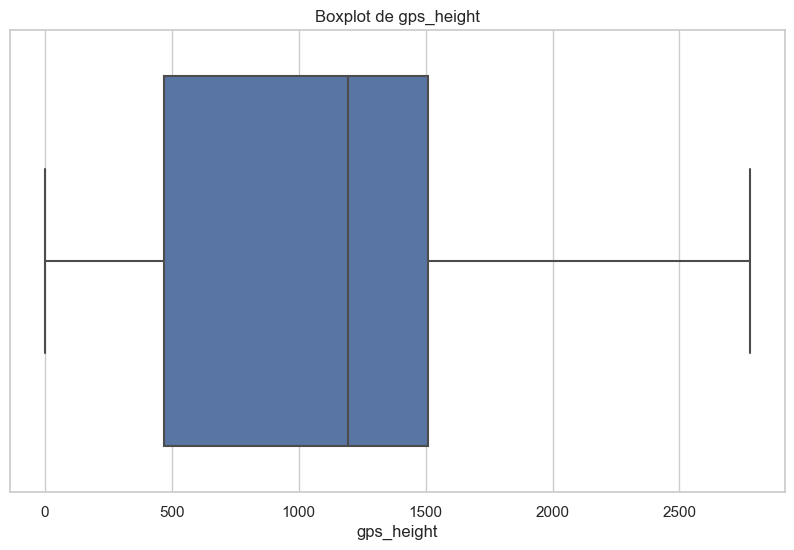

C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


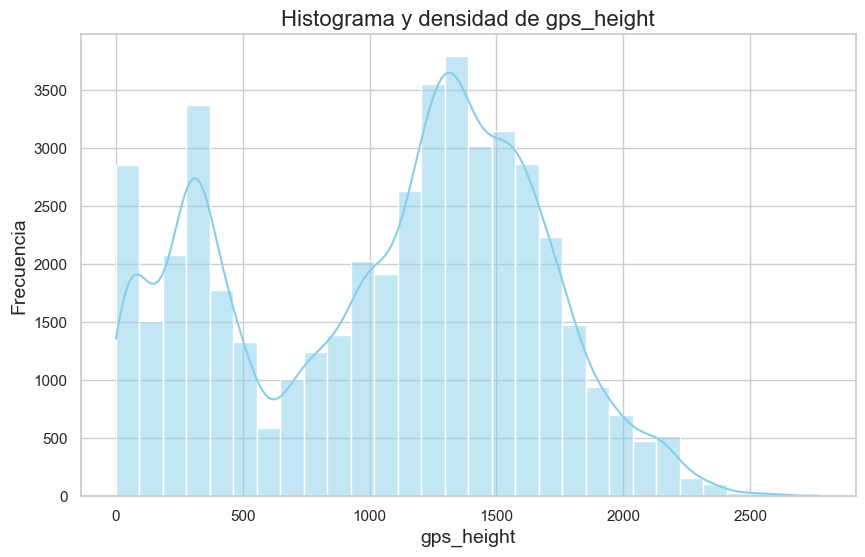

In [35]:
# Reemplazamos valores menores o iguales a 0 por NaN en la columna 'gps_height'
dataframe_select['gps_height'] = dataframe_select['gps_height'].mask(dataframe_select['gps_height'] <= 0, np.nan)

# Imprimir la cantidad de valores NaN en la columna 'gps_height'
print('Valores no válidos para la variable GPS_HEIGHT:', dataframe_select['gps_height'].isna().sum())

# Agrupación para ver los valores
display(dataframe_select['gps_height'].describe())

# Dibujamos el boxplot
plt.figure(figsize = (10, 6))
sns.boxplot(x = dataframe_select['gps_height'])
plt.title('Boxplot de gps_height')
plt.show()

# Dibujamos el histograma y la función de densidad estimada
sns.set(style="whitegrid") # Configuración del estilo de los gráficos
plt.figure(figsize=(10, 6)) # Crear el gráfico con histograma y densidad
sns.histplot(dataframe_select['gps_height'], kde=True, bins=30, color='skyblue')
plt.title('Histograma y densidad de gps_height', fontsize=16) # Títulos y etiquetas
plt.xlabel('gps_height', fontsize=14) # Títulos y etiquetas
plt.ylabel('Frecuencia', fontsize=14) # Títulos y etiquetas
plt.show()

Observamos que ahora tenemos una distribución más coherente, pero el número de valores a imputar es bastante alto (27.530 registros). Dado que la altura sobre el nivel del mar es una característica que también se puede considerar geográfica, al igual que hicimos con las _longitude_ y _latitude_ la vamos imputar por la media de esta variable a nivel _region_ - _district_code_ (o en su defecto, únicamente _region_).


In [36]:
# 1. CALCULAMOS LAS MEDIAS A NIVEL REGION - DISTRITO
# Calcular promedios en distritos dentro de regiones
dataframe_select['district_gps_height'] = dataframe_select.groupby(['region', 'district_code'])['gps_height'].transform(lambda x: x.mean(skipna=True))

# Calcular promedios en regiones
# En caso de que los promedios a imputar no tenga la combinación Region - District_Code informada, lo informaremos únicamente a nivel region
dataframe_select['region_gps_height'] = dataframe_select.groupby('region')['gps_height'].transform(lambda x: x.mean(skipna=True))


# 2. IMPUTAMOS VALORES
# "Imputar" valores faltantes de longitud/latitud
dataframe_select['gps_height'] = np.where(dataframe_select['gps_height'].notna(), dataframe_select['gps_height'],
                             np.where(dataframe_select['district_gps_height'].notna(), dataframe_select['district_gps_height'], dataframe_select['region_gps_height']))

# Eliminamos la columnas auxiliares
dataframe_select = dataframe_select.drop(columns=['district_gps_height','region_gps_height'])


# 3. COMPROBACIÓN
# Observamos que efectivamente, se ha producido el cambio correctamente (miramos valores mínimos y máximos).
display(dataframe_select[['gps_height']].describe())


# 4. ANÁLISIS SIN RESULTADO: regiones enteras sin ningún valor de 'gps_height' informado.
dataframe_select[dataframe_select['gps_height'].isna()].region.value_counts()

,gps_height
count,59073.000000
mean,1060.145757
std,562.256247
min,1.000000
25%,546.000000
50%,1199.346072
75%,1416.000000
max,2777.000000


region
Mbeya     5758
Kagera    4174
Dodoma    2779
Tabora    2466
Name: count, dtype: int64

Observamos que aún existen varias regiones (Mbeya, Kagera, Dodoma y Tabora) que no tienen la variable _gps_height_ completamente informada. Para imputar estos valores faltantes, utilizaremos el método KNN, basándonos en las coordenadas de _longitude_ y _latitude_ (previamente imputadas). Consideramos que tiene sentido que zonas ubicadas en puntos geográficos cercanos tengan valores similares para la variable _gps_height_.


,gps_height
count,74250.000000
mean,1153.249091
std,579.157414
min,1.000000
25%,800.400000
50%,1268.000000
75%,1459.000000
max,2777.000000


C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


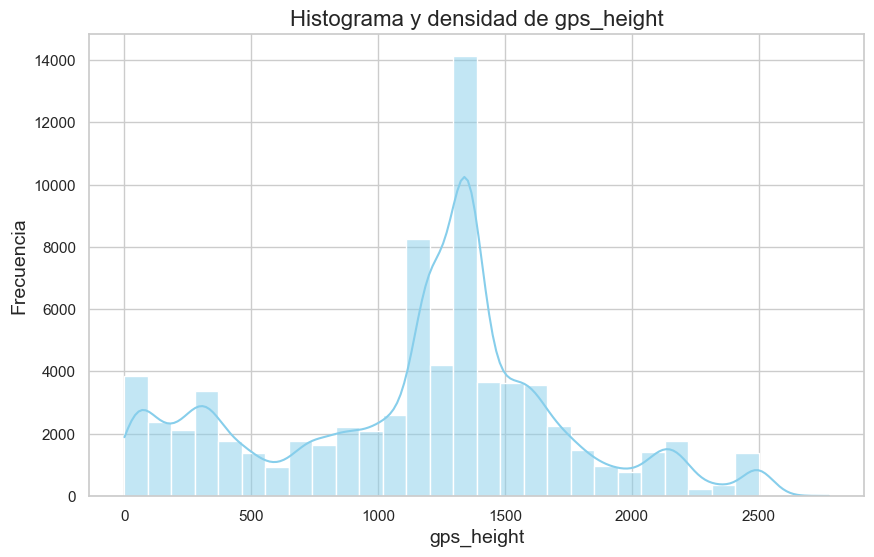

In [37]:
# Selecciona solo las columnas relevantes
data = dataframe_select[['longitude', 'latitude', 'gps_height']]

# Crear el imputador KNN
imputer = skl_imp.KNNImputer(n_neighbors=5)

# Imputar los valores faltantes
data_imputed = imputer.fit_transform(data)

# Volver a insertar los valores imputados en el DataFrame original
dataframe_select['gps_height'] = data_imputed[:, 2]  # La columna 'gps_height' es la tercera (índice 2)

# Mostrar los resultados
display(dataframe_select[['gps_height']].describe())

# Dibujamos el histograma y la función de densidad estimada
sns.set(style="whitegrid") # Configuración del estilo de los gráficos
plt.figure(figsize=(10, 6)) # Crear el gráfico con histograma y densidad
sns.histplot(dataframe_select['gps_height'], kde=True, bins=30, color='skyblue')
plt.title('Histograma y densidad de gps_height', fontsize=16) # Títulos y etiquetas
plt.xlabel('gps_height', fontsize=14) # Títulos y etiquetas
plt.ylabel('Frecuencia', fontsize=14) # Títulos y etiquetas
plt.show()

Vemos que se han imputado los valores mayoritariamente sobre 1.300 m. Eliminamos el resto de variables asociadas a la información geográfica (_region_code_,_district_code_, _ward_, _subvillage_) ya que no nos aportan mayor información.


In [38]:
# Eliminamos las columnas mencionadas
dataframe_select = dataframe_select.drop(columns=['region_code','district_code', 'ward', 'subvillage'])

### Variables con información variada

Encontramos otras variables que nos dan información variada:

- **amount_tsh**: se entiende como la distancia vertical en pies entre el nivel libre de la fuente de suministro y el punto de descarga libre o la superficie libre del líquido de descarga.
- **wpt_name**: parece indicar el "name of the waterpoint if there is one" o nombre del punto de agua si lo hay.
- **num_private**: se refiere al número de fuentes de agua privadas dentro del área. Esta variable probablemente indica el recuento de fuentes de agua que son de propiedad privada, a diferencia de las de acceso público.
- **population**: cantidad de personas que usan la tubería.
- **public_meeting**: si se llevó a cabo o no una reunión pública sobre el pozo o la bomba de agua específicos, únicamente toma valores "True"/"False".
- **permit**: nos indican si el punto de agua está permitido, únicamente toma valores "True"/"False".

Las variables **amount_tsh** o **population** son variables numéricas que hacen referencia a información variada por lo que de momento las dejamos igual.


**wpt_name**: tiene 3.399 valores únicos, lo cual es un volumen demasiado grande para este tipo de análisis. Dado su nombre y significado, consideramos que no debería tener relevancia dentro del análisis, por lo que hemos decidido eliminar esta variable. Tras algunas pruebas anteriores, puedo concluir que darle importancia a esta variable probablemente resultaría en un sobreajuste significativo del modelo, dificultando su capacidad para generalizar bien sobre nuevos datos.


In [39]:
# Eliminamos la columna 'wpt_name'
dataframe_select = dataframe_select.drop(columns=['wpt_name'])

**num_private**: de los 59.400 registros totales, 58.643 de ellos toman valor 0 por lo que no parece que esta variable nos vaya a aportar demasiada información respecto a la variable objetivo al estar tan desbalanceada. Por tanto, la eliminamos.


In [40]:
# Eliminamos la columna 'num_private'
dataframe_select = dataframe_select.drop(columns=['num_private'])

Recordemos que las variables **public_meeting** y **permit** vemos que tienen algunos missings. Dada sus naturalezas booleana interpretaremos estos missings como "False".


In [41]:
# Reemplazar los valores faltantes con False
dataframe_select['public_meeting'] = dataframe_select['public_meeting'].fillna(False)
dataframe_select['permit'] = dataframe_select['permit'].fillna(False)

# Comprobamos los resultados
grouped_counts = dataframe_select.groupby(['public_meeting']).size().reset_index(name='counts')
display(grouped_counts)

# Comprobamos los resultados
grouped_counts = dataframe_select.groupby(['permit']).size().reset_index(name='counts')
display(grouped_counts)

,public_meeting,counts
0,False,10501
1,True,63749


,permit,counts
0,False,25644
1,True,48606


### Variable sobre fechas

Variables sobre fechas como pueden ser:

- **date_recorded**: fecha en la que se realizó el registro de los datos.
- **construction_year**: año de construcción, puede ser interesante que tuberías más antiguas sean más propensas a romperse o necesitar reparaciones.


De momento **date_recorded** no nos aporta ninguna información, por lo que la eliminamos.


In [42]:
# Eliminamos la columna 'date_recorded'
dataframe_select = dataframe_select.drop(columns=['date_recorded'])

**construction_year**: vamos a analizar esta variable más detenidamente. Vimos en la agrupación por valores que podía estar muy sesgada hacia la izquierda al tomar muchos valores igual a 0. Obviamente, este no es un valor válido por lo que lo tomaremos como missing e imputaremos.


construction_year
0       25969
2010     3314
2008     3243
2009     3196
2000     2578
2007     1960
2006     1892
2011     1591
2003     1579
2004     1417
Name: count, dtype: int64

C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


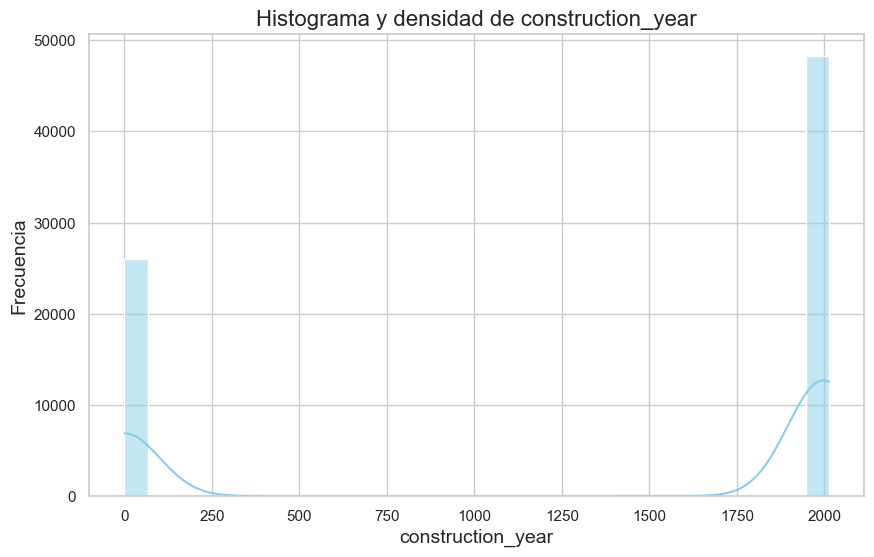

In [43]:
# Agrupación para ver los valores
display(dataframe_select['construction_year'].value_counts().head(10))

# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico con histograma y densidad
plt.figure(figsize=(10, 6))
sns.histplot(dataframe_select['construction_year'], kde=True, bins=30, color='skyblue')

# Títulos y etiquetas
plt.title('Histograma y densidad de construction_year', fontsize=16)
plt.xlabel('construction_year', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()


Habría que imputar 25.969 registros. Para ello, vamos a realizar una imputación por el método KNN apoyándonos únicamente en las variables _longiude_ y _latitude_ asumiendo que bombas de agua construidas en ubicaciones geográficas cercanas tienden a tener años de construcción similares. Además como vimos en la matriz de correlaciones, las variables con las que más relación guarda _construction_year_ es con _longiude_ y _latitude_ con lo que tiene sentido apoyarnos en estas variables.


Valores no válidos para la variable CONSTRUCTION_YEAR: 25969


count    48281.000000
mean      1996.870943
std         12.440524
min       1960.000000
25%       1988.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

,construction_year
count,74250.000000
mean,1996.623211
std,11.385103
min,1960.000000
25%,1990.000000
50%,1999.800000
75%,2006.000000
max,2013.000000


C:\Users\abr28\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


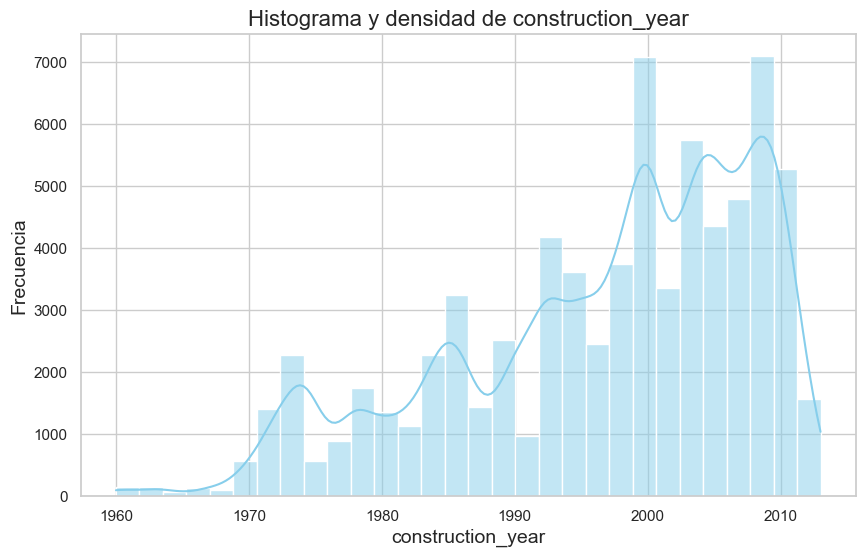

In [44]:
# Reemplazamos valores menores o iguales a 0 por NaN en la columna 'construction_year'
dataframe_select['construction_year'] = dataframe_select['construction_year'].mask(dataframe_select['construction_year'] <= 0, np.nan)

# Imprimir la cantidad de valores NaN en la columna 'construction_year'
print('Valores no válidos para la variable CONSTRUCTION_YEAR:', dataframe_select['construction_year'].isna().sum())

# Agrupación para ver los valores
display(dataframe_select['construction_year'].describe())

# Selecciona solo las columnas relevantes
data = dataframe_select[['longitude', 'latitude', 'construction_year']]

# Crear el imputador KNN
imputer = skl_imp.KNNImputer(n_neighbors=5)

# Imputar los valores faltantes
data_imputed = imputer.fit_transform(data)

# Volver a insertar los valores imputados en el DataFrame original
dataframe_select['construction_year'] = data_imputed[:, 2]  # La columna 'construction_year' es la tercera (índice 2)

# Mostrar los resultados
display(dataframe_select[['construction_year']].describe())

# Dibujamos el histograma y la función de densidad estimada
sns.set(style="whitegrid") # Configuración del estilo de los gráficos
plt.figure(figsize=(10, 6)) # Crear el gráfico con histograma y densidad
sns.histplot(dataframe_select['construction_year'], kde=True, bins=30, color='skyblue')
plt.title('Histograma y densidad de construction_year', fontsize=16) # Títulos y etiquetas
plt.xlabel('construction_year', fontsize=14) # Títulos y etiquetas
plt.ylabel('Frecuencia', fontsize=14) # Títulos y etiquetas
plt.show()

**_Discusión sobre la Antigüedad de la Bomba de Agua_**

Hemos considerado una idea que, aunque parecía tener sentido, no ha mejorado los resultados del modelo.

Reflexionando sobre la importancia que veremos posteriormente de la variable _construction_year_ en el modelo, se nos ocurrió calcular la **antigüedad de la bomba de agua** en el momento de la medición. Este enfoque nos parece más relevante porque el estado de una bomba de agua no es igual si fue construida en 1990 y la medición del _Status_group_ se realizó en 1992, comparado con una bomba construida en 1990 y medida en 2013. En el segundo caso, la bomba tendría mayor antigüedad, lo que podría reducir la probabilidad de que esté en estado _functional_.

Por lo tanto, dejamos la propuesta del campo **age** para reflejar esta antigüedad.


### Variables con demasiada volumetría de clases

A parte de todas las variables anteriores, tenemos variables como **funder** o **installer** con un gran número de clases. Intentaremos reducir el número de clases agrupando aquellas categorías con poca representatividad (menos de 600 registros) en una nueva categoría que se llame _"other"_.


In [45]:
# Antes de realizar las agrupaciones nos copiamos el fichero anterior para poder realizar las modificaciones que queramos.
dataframe_agrupado = dataframe_select.copy()

In [46]:
# VARIABLE 'FUNDER'
# Contar la frecuencia de cada categoría en la columna
category_counts = dataframe_agrupado['funder'].value_counts()

# Identificar las categorías con menos de 600 registros
small_categories = category_counts[category_counts < 600].index

# Reemplazar esas "small_categories" por "other"
dataframe_agrupado['funder'] = dataframe_agrupado['funder'].apply(lambda x: 'other' if x in small_categories else x)


In [47]:
# VARIABLE 'INSTALLER'
# Contar la frecuencia de cada categoría en la columna
category_counts = dataframe_agrupado['installer'].value_counts()

# Identificar las categorías con menos de 600 registros
small_categories = category_counts[category_counts < 600].index

# Reemplazar esas "small_categories" por "other"
dataframe_agrupado['installer'] = dataframe_agrupado['installer'].apply(lambda x: 'other' if x in small_categories else x)


Comprobamos los resultados y el número de clases resultantes que tenemos.


In [48]:
display(dataframe_agrupado[['funder', 'installer']].describe())

,funder,installer
count,69743,69718
unique,21,16
top,other,other
freq,33057,33230


Recordamos que estas dos variables tenían valores sin informar (missings), de hecho, se puede observar que en el count no se tienen los 74.250 registros iniciales. Los imputaremos por la moda, que en este caso tras la primera reducción de niveles, se nos incluirán dentro del grupo "other", decisión con la que me siento cómodo.


,funder,installer
count,74250,74250
unique,21,16
top,other,other
freq,37564,37762


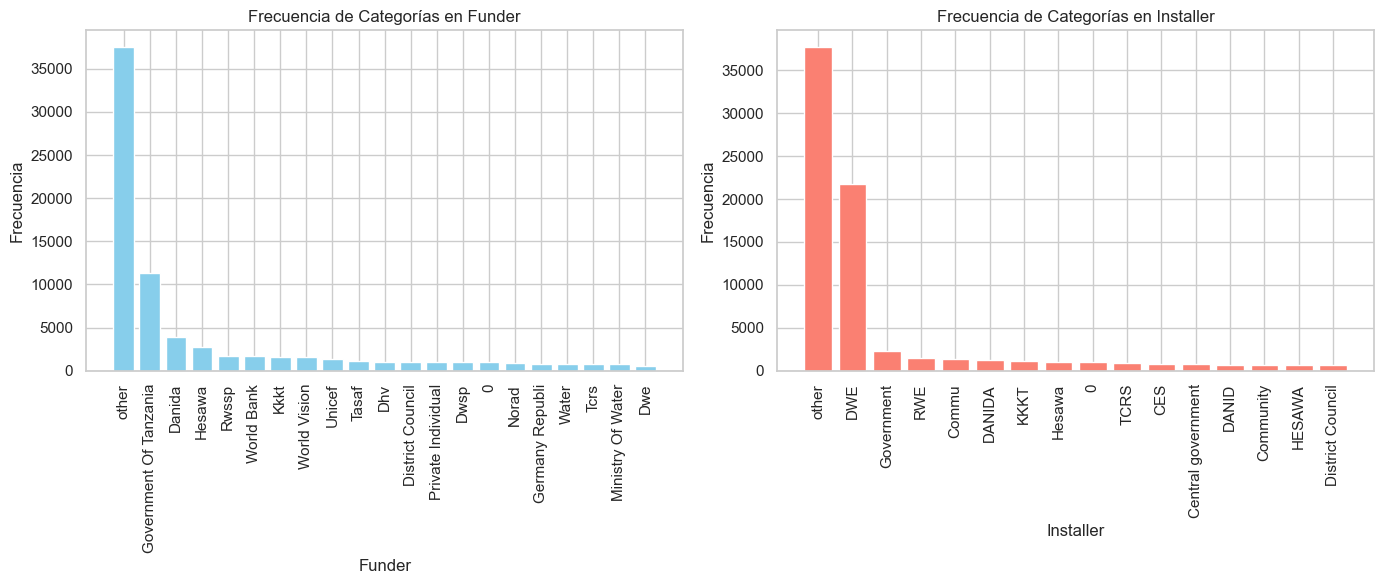

In [49]:
# Imputamos variables por moda.
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

# Imputamos la columna 'funder' y la actualizamos en el DataFrame
dataframe_agrupado['funder'] = imputer_moda.fit_transform(dataframe_agrupado[['funder']]).ravel()
dataframe_agrupado.index = dataframe_agrupado.index # Mantenemos el índice original

# Imputamos la columna 'installer' y la actualizamos en el DataFrame
dataframe_agrupado['installer'] = imputer_moda.fit_transform(dataframe_agrupado[['installer']]).ravel()
dataframe_agrupado.index = dataframe_agrupado.index # Mantenemos el índice original

# Comprobar la información del DataFrame
display(dataframe_agrupado[['funder', 'installer']].describe())


# CONSTRUIR HISTOGRAMA
# Contar la frecuencia de cada categoría
funder_counts = dataframe_agrupado['funder'].value_counts()
installer_counts = dataframe_agrupado['installer'].value_counts()

# Configurar la figura y los ejes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histograma para 'funder'
ax[0].bar(funder_counts.index, funder_counts.values, color='skyblue')
ax[0].set_title('Frecuencia de Categorías en Funder')
ax[0].set_xlabel('Funder')
ax[0].set_ylabel('Frecuencia')
ax[0].tick_params(axis='x', rotation=90)

# Histograma para 'installer'
ax[1].bar(installer_counts.index, installer_counts.values, color='salmon')
ax[1].set_title('Frecuencia de Categorías en Installer')
ax[1].set_xlabel('Installer')
ax[1].set_ylabel('Frecuencia')
ax[1].tick_params(axis='x', rotation=90)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Para la variable _installer_ vemos que únicamente se nos han quedado 16 valores únicos y para la variable _funder_ vemos que se nos han quedan 21 valores únicos. Pese a que es un número mayor al deseado, mantenemos este número de clases pese al riesgo de sobrecarga en el modelo.


## 3. Dataset final

Tras haber analizado individualmente todas las variables, obtenemos nuestro dataset final con toda la información depurada y lista para entrenar nuestros modelos.


In [50]:
# Nos copiamos el fichero anterior
dataframe_final = dataframe_agrupado.copy()

In [51]:
display(dataframe_final.head()) # Pequeña muestra del dataframe final
display(dataframe_final.info()) # Información del dataframe final
display(dataframe_final.describe()) # Describe de las columnas numéricas del dataframe final
display(dataframe_final[dataframe_final.select_dtypes(exclude=['int64', 'float64']).columns].describe(include='all')) # Describe de las columnas no numéricas del dataframe final

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,other,1390.000000,other,34.938093,-9.856322,Lake Nyasa,Iringa,other,109,True,VWC,False,1999.0,gravity,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe
8776,0.0,other,1399.000000,other,34.698766,-2.147466,Lake Victoria,Mara,other,280,False,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe
34310,25.0,other,686.000000,other,37.460664,-3.821329,Pangani,Manyara,other,250,True,VWC,True,2009.0,gravity,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple
67743,0.0,Unicef,263.000000,other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,other,58,True,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple
19728,0.0,other,1246.607643,other,31.130847,-1.825359,Lake Victoria,Kagera,other,0,True,VWC,True,2005.0,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe


<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 69572 to 68707
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   funder                 74250 non-null  object 
 2   gps_height             74250 non-null  float64
 3   installer              74250 non-null  object 
 4   longitude              74250 non-null  float64
 5   latitude               74250 non-null  float64
 6   basin                  74250 non-null  object 
 7   region                 74250 non-null  object 
 8   lga                    74250 non-null  object 
 9   population             74250 non-null  int64  
 10  public_meeting         74250 non-null  bool   
 11  scheme_management      74250 non-null  object 
 12  permit                 74250 non-null  bool   
 13  construction_year      74250 non-null  float64
 14  extraction_type_group  74250 non-null  object 
 15  ext

None

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,1153.249091,35.104994,-5.787021,180.750828,1996.623211
std,2906.762364,579.157414,2.581922,2.816543,471.086120,11.385103
min,0.000000,1.000000,29.607122,-11.649440,0.000000,1960.000000
25%,0.000000,800.400000,33.263917,-8.525675,0.000000,1990.000000
50%,0.000000,1268.000000,34.907475,-5.026540,25.000000,1999.800000
75%,20.000000,1459.000000,37.181685,-3.325170,215.000000,2006.000000
max,350000.000000,2777.000000,40.345193,-0.998464,30500.000000,2013.000000


,funder,installer,basin,region,lga,public_meeting,scheme_management,permit,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type
count,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,21,16,9,21,3,2,11,2,12,7,12,5,7,8,5,9,3,7
top,other,other,Lake Victoria,Iringa,other,True,VWC,True,gravity,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe
freq,37564,37762,12871,6599,60318,63749,50764,48606,33263,33263,50624,65538,31712,63505,41522,21216,57286,35628


### Transformación de las variables categóricas a dummies

Realizamos la transformación a dummies mediante _get_dummies_ de todas las variables categóricas, excluyendo la variable objetivo _status_group_.


In [52]:
cat_cols_process = dataframe_final.select_dtypes(include=['object','category']).columns
print('Número de clases por cada variable categórica:')
dataframe_final[cat_cols_process].nunique()

Número de clases por cada variable categórica:


funder                   21
installer                16
basin                     9
region                   21
lga                       3
scheme_management        11
extraction_type_group    12
extraction_type_class     7
management               12
management_group          5
payment_type              7
water_quality             8
quantity                  5
source                    9
source_class              3
waterpoint_type           7
dtype: int64

Debemos transformar nuestras variables categóricas a dummies.


In [53]:
# Crear una copia del DataFrame original para trabajar con las columnas dummy
df_final = dataframe_final.copy()

# Bucle para convertir cada columna categórica en dummies y eliminar la columna original
for col in cat_cols_process:
    # Convertimos la columna categórica en dummies
    dummies = pd.get_dummies(df_final[col], prefix=col, dtype=int)
    
    # Concatenamos las columnas dummy con el DataFrame original
    df_final = pd.concat([df_final, dummies], axis=1)
    
    # Eliminamos la columna original
    df_final.drop(col, axis=1, inplace=True)
    
# Verificar el resultado
df_final.info()

df_final.head()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 69572 to 68707
Columns: 164 entries, amount_tsh to waterpoint_type_other
dtypes: bool(2), float64(5), int32(156), int64(1)
memory usage: 48.3 MB


,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,funder_0,funder_Danida,funder_Dhv,funder_District Council,funder_Dwe,funder_Dwsp,funder_Germany Republi,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Ministry Of Water,funder_Norad,funder_Private Individual,funder_Rwssp,funder_Tasaf,funder_Tcrs,funder_Unicef,funder_Water,funder_World Bank,funder_World Vision,funder_other,installer_0,installer_CES,installer_Central government,installer_Commu,installer_Community,installer_DANID,installer_DANIDA,installer_DWE,installer_District Council,installer_Government,installer_HESAWA,installer_Hesawa,installer_KKKT,installer_RWE,installer_TCRS,installer_other,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_other,lga_rural,lga_urban,scheme_management_Company,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn,extraction_type_group_wind-powered,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390.000000,34.938093,-9.856322,109,True,False,1999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
8776,0.0,1399.000000,34.698766,-2.147466,280,False,True,2010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

## Conclusiones del análisis exploratorio y tratamiento de variables

Nuestras conclusiones sobre el tratamiento escogido tras analizar los outliers y missings es el siguiente:

- Imputación de missings en las variables categóricas a través de la moda: **scheme_management**, **public_meeting**, **permit**, **installer** y **funder**.
- Imputación para **longitude** y **latitude**: pasamos a missigns aquellos registros con valor (0, 0) e imputamos por la media de estas variables en la región - distrito correspondiente (o región en su defecto).
- Imputación para **gps_height** y **construction_year**: imputamos aquellos registros que toman valor 0 (o negativo) ya que los consideramos como missings.
- Reducción de clases para las variables **installer** y **funder** agrupando las categorías con un volumen menor a 600 registros.


# 4. Entrenamiento y evaluación del modelo


Leemos el fichero con la variable objetivo a predecir: **status_group**.


In [54]:
# Lectura del fichero
y_train_orig = pd.read_csv('input/training_set_labels.csv')
y_train_orig.set_index('id', inplace=True) # Guardar la columna 'id' como índice

y_train_orig.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


Cambiamos el formato de la variable objetivo _status_group_ para que sea más entendible para el modelo (a formato numérico).


In [55]:
# Diccionario de mapeo
status_group_mapping = {
    'non functional': 0,
    'functional needs repair': 1,
    'functional': 2
}

# Reemplazar los valores en la columna 'status'
y_train_orig['status_group_map'] = y_train_orig['status_group'].replace(status_group_mapping)
y_train_map = y_train_orig.drop('status_group', axis=1)

y_train_map.status_group_map.value_counts().sort_index(ascending=True)

status_group_map
0    22824
1     4317
2    32259
Name: count, dtype: int64

### Partición de la muestra en train y test

Juntamos ambos dataframes para poder tener asignado a cada uno de los _id_ su correspondiente valor para la variable objetivo ya que no sabemos si vienen en el mismo orden. Nos quedamos únicamente con nuestros datos de entrenamiento (recordamos que eran 59.400 registros).


In [56]:
# Realizamos el cruce
df_final_OK = pd.merge(df_final, y_train_map, how='inner', left_index=True, right_index=True)

# Verificamos resultados (nos tiene que dar 59.400 registros)
display(df_final_OK.head())
df_final_OK.info()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,funder_0,funder_Danida,funder_Dhv,funder_District Council,funder_Dwe,funder_Dwsp,funder_Germany Republi,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Ministry Of Water,funder_Norad,funder_Private Individual,funder_Rwssp,funder_Tasaf,funder_Tcrs,funder_Unicef,funder_Water,funder_World Bank,funder_World Vision,funder_other,installer_0,installer_CES,installer_Central government,installer_Commu,installer_Community,installer_DANID,installer_DANIDA,installer_DWE,installer_District Council,installer_Government,installer_HESAWA,installer_Hesawa,installer_KKKT,installer_RWE,installer_TCRS,installer_other,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_other,lga_rural,lga_urban,scheme_management_Company,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn,extraction_type_group_wind-powered,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group_map
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390.000000,34.938093,-9.856322,109,True,False,1999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,2
8776,0.0,1399.000000,34.698766,-2.147466,280,False,True,2010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Columns: 165 entries, amount_tsh to status_group_map
dtypes: bool(2), float64(5), int32(156), int64(2)
memory usage: 39.1 MB


Debemos excluir la variable objetivo de nuestra partición _train_. En este caso, realizaremos la partición de manera estratificada. Esto quiere decir que se mantendrán las proporciones de las clases representadas en la muestra utilizada para el entrenamiento y validación del modelo.


In [57]:
X_train, X_test, y_train, y_test = train_test_split (df_final_OK.drop('status_group_map', axis=1), 
                                                     df_final_OK.status_group_map,
                                                     test_size = 0.2,
                                                     random_state = 14,
                                                     stratify = df_final_OK.status_group_map)

# Comprobamos dimensiones
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (47520, 164) (47520,)
Testing dataset shape: (11880, 164) (11880,)


### Evaluación del modelo

Probaremos distintas técnicas de Machine Learning con el fin de obtener los mejores resultados. Añadimos la función que nos permitirá consultar más en detalle la evaluación de los modelos.


In [58]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

def saca_metricas(y1, y2):
    print('Matriz de confusión:')
    print(confusion_matrix(y1, y2))
    
    print('Accuracy:')
    print(accuracy_score(y1, y2))
    
    print('Precision (macro):')
    print(precision_score(y1, y2, average='macro'))
    
    print('Recall (macro):')
    print(recall_score(y1, y2, average='macro'))
    
    print('F1 Score (macro):')
    print(f1_score(y1, y2, average='macro'))

    # Para calcular el AUC multiclase
    y1_bin = label_binarize(y1, classes=np.unique(y1))
    y2_bin = label_binarize(y2, classes=np.unique(y1))

    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()

    for i in range(y1_bin.shape[1]):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y1_bin[:, i], y2_bin[:, i])
        roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

    # Calcular el AUC promedio (macro)
    all_fpr = np.unique(np.concatenate([false_positive_rate[i] for i in range(y1_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(y1_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, false_positive_rate[i], true_positive_rate[i])

    mean_tpr /= y1_bin.shape[1]

    macro_roc_auc = auc(all_fpr, mean_tpr)

    print('AUC (macro):')
    print(macro_roc_auc)

    plt.figure()
    plt.plot(all_fpr, mean_tpr, label='ROC macro-average (AUC = %0.2f)' % macro_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


## 4.1. Random Forest


Accuracy: 0.803956228956229
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      4565
           1       0.52      0.37      0.43       863
           2       0.81      0.88      0.84      6452

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880

Matriz de confusión:
[[3562   89  914]
 [ 128  315  420]
 [ 577  201 5674]]
Accuracy:
0.803956228956229
Precision (macro):
0.7216952695577898
Recall (macro):
0.674902601391386
F1 Score (macro):
0.6929527570407473
AUC (macro):
0.7760408049956026


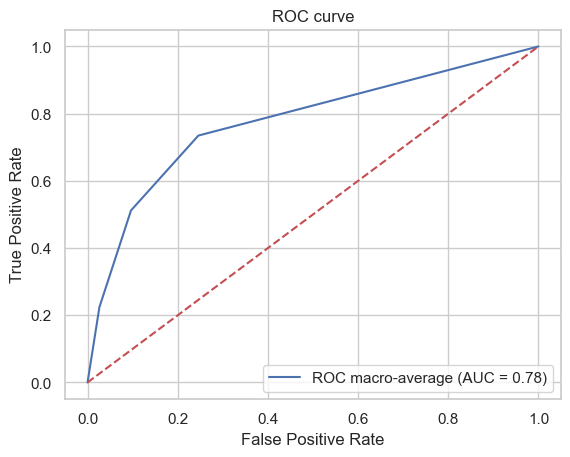

In [59]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=14)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', report)

saca_metricas(y_test, y_pred)

## 4.1 (Mod) Random Forest (100% training)

Vamos a entrenar un modelo de Random Forest utilizando el 100% de la muestra. Dado que hemos observado que el modelo de Random Forest es el que mejor funciona, decidimos probar este enfoque completo.


In [60]:
# Usar todo el dataset para entrenamiento
X_train_100 = df_final_OK.drop('status_group_map', axis=1)
y_train_100 = df_final_OK['status_group_map']

# Comprobamos dimensiones
print('Training dataset shape:', X_train_100.shape, y_train_100.shape)

# Initialize Random Forest Classifier
rf_100 = RandomForestClassifier(n_estimators=100, random_state=14)

# Train the model
rf_100.fit(X_train_100, y_train_100)

Training dataset shape: (59400, 164) (59400,)


RandomForestClassifier(random_state=14)

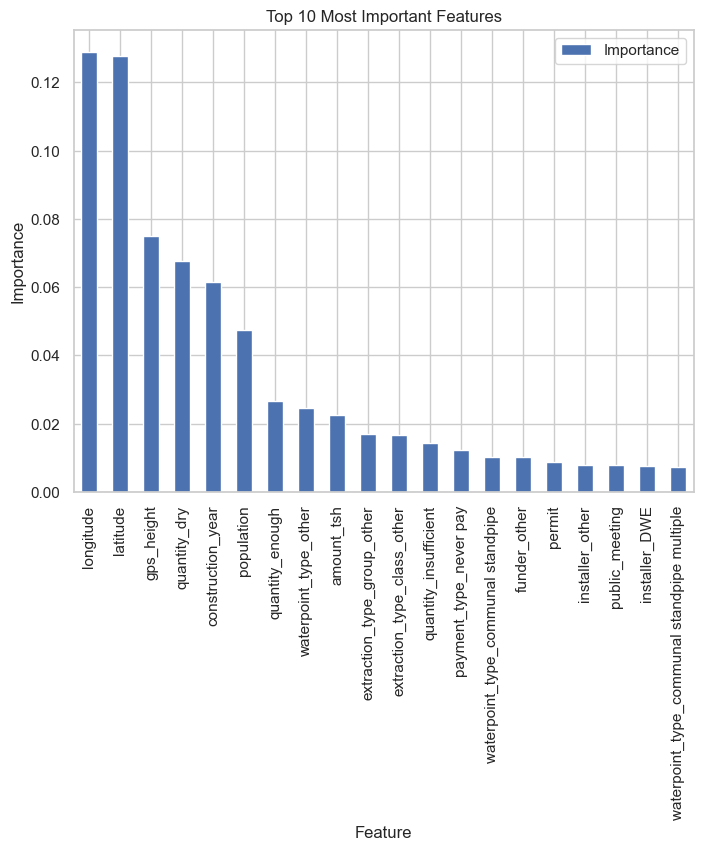

In [61]:
# Crear un DataFrame con las importancias de las características
feat_importances = pd.DataFrame(rf_100.feature_importances_, index=X_train_100.columns, columns=["Importance"])

# Ordenar las características por importancia
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Seleccionar las 10 primeras características más importantes
top_10_features = feat_importances.head(20)

# Graficar las 10 primeras características más importantes
top_10_features.plot(kind='bar', figsize=(8,6))
plt.title("Top 10 Most Important Features")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


## 4.2. Decision Tree


Accuracy: 0.7518518518518519
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      4565
           1       0.37      0.39      0.38       863
           2       0.80      0.80      0.80      6452

    accuracy                           0.75     11880
   macro avg       0.64      0.65      0.64     11880
weighted avg       0.75      0.75      0.75     11880

Matriz de confusión:
[[3458  183  924]
 [ 161  333  369]
 [ 923  388 5141]]
Accuracy:
0.7518518518518519
Precision (macro):
0.6429126061652498
Recall (macro):
0.646724399155017
F1 Score (macro):
0.6447486914833885
AUC (macro):
0.750324377877804


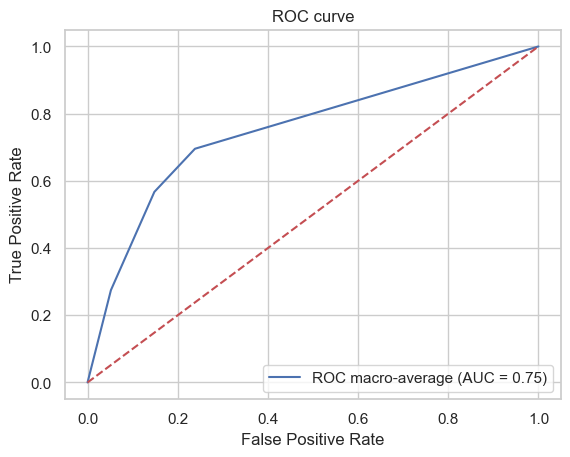

In [62]:
# Initialize Random Forest Classifier
dt = DecisionTreeClassifier(random_state=14)

# Train the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', report)

saca_metricas(y_test, y_pred)

## 4.3. XGBClassifier


Accuracy: 0.774074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.67      0.75      4565
           1       0.67      0.18      0.29       863
           2       0.75      0.93      0.83      6452

    accuracy                           0.77     11880
   macro avg       0.75      0.59      0.62     11880
weighted avg       0.78      0.77      0.76     11880

Matriz de confusión:
[[3067   34 1464]
 [ 127  159  577]
 [ 438   44 5970]]
Accuracy:
0.774074074074074
Precision (macro):
0.7535165723773893
Recall (macro):
0.593795514185175
F1 Score (macro):
0.6209894434200138
AUC (macro):
0.720175793292562


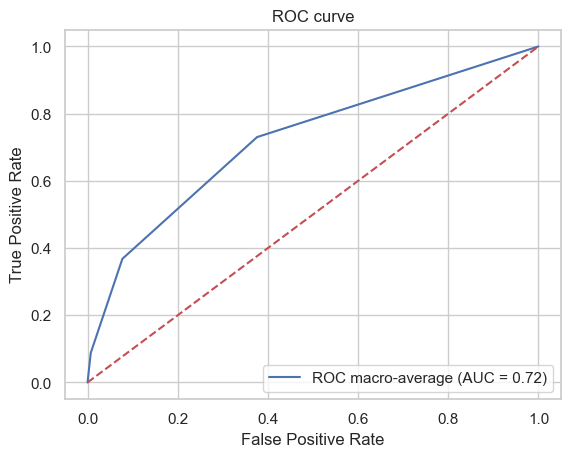

In [63]:
# Initialize Random Forest Classifier
XGB = XGBClassifier(n_jobs=-1, n_estimators=30, random_state=14)

# Train the model
XGB.fit(X_train, y_train)

# Make predictions
y_pred = XGB.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', report)

saca_metricas(y_test, y_pred)

## 5. Tuneo de hiperparámetros

Ajustaremos cuidadosamente los hiperparámetros con el fin de obtener un modelo más preciso, robusto y confiable.


Establecemos los intervalos sobre los que queremos que se vayan probando los hiperparámetros y dejamos que la función **GridSearchCV** busque los mejores parámetros. Esta función exige mucho al ordenador (horas) por lo que tenemos que tener cuidado los valores que le indicamos para que encuentre el mejor modelo.


In [64]:
# Acotamos los parámetros
grid_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [22, 23, 24]
}


# Marca el tiempo de inicio
import time
start_time = time.time()


# Inicializamos el modelo sin entrenarlo
modelo_inicial = RandomForestClassifier()
# Configuramos la búsqueda en grid del mejor modelo
model_grid = GridSearchCV(estimator = modelo_inicial,
                     param_grid = grid_param, # Tiene que ser un diccionario
                     scoring = 'accuracy', # Qué parametro quiero mejorar: f1, recall...
                     cv = StratifiedKFold(n_splits=5), # Validación cruzada, me evita el overfitting
                     n_jobs=-1) # Que utilice todos los recursos del ordenador

# Buscamos el mejor modelo
model_grid.fit(X_train, y_train)

# Mostramos los resultados
print('Mejores parámetros para el modelo:', model_grid.best_params_)
print('\nMejor puntuación obtenida:', model_grid.best_score_)

# Calcula el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nEl código tardó {elapsed_time:.4f} segundos en ejecutarse.")

Mejores parámetros para el modelo: {'max_depth': 23, 'n_estimators': 200}

Mejor puntuación obtenida: 0.8083964646464645

El código tardó 309.4289 segundos en ejecutarse.


Vemos que la mejor combinación (en temas de accuracy) es la definida por el siguiente par: {'max_depth': 23, 'n_estimators': 200}.

Esta opción obtiene una precisión de 0.8070, algo mejor que el modelo de Random Forest que habíamos elegido. Entrenamos los nuevos modelos con estos parámetros y realizamos las predicciones en base a ellos.


## 6. Balanceo de la variable objetivo

La variable objetivo _status_group_ tiene tres clases con la siguiente distribución:

- Clase 0 (non functional): 22.824 registros (38'42%).
- Clase 1 (functional needs repair): 4.317 registros (7'86%).
- Clase 2 (functional): 32.259 registros (54'31%).

Observamos que está claramente desbalanceada, de manera evidente para la clase 1 que es la menos representada. Este desbalanceo puede causar que nuestro modelo "no sepa aprender" de estos casos al tener una muestra tan reducida y que el aprendizaje se vuelva sesgado hacia las clases mayoritarias (las clases 0 o 2).

Por ello, vamos a utilizar la técnica de sobremuestreo de la clases minoritaria con SMOTE (genera nuevas muestras sintéticas para la clase minoritaria en lugar de simplemente replicar las existentes) hasta alcanzar una representatividad suficiente, que no tiene por qué ser igual a las otras clases.


In [65]:
# Situación antes del balanceo
print("Antes del OverSampling, número de registros con clase 0 (non functional): {}".format(sum(df_final_OK.status_group_map==0)))
print("Antes del OverSampling, número de registros con clase 1 (functional needs repair): {}".format(sum(df_final_OK.status_group_map==1)))
print("Antes del OverSampling, número de registros con clase 2 (functional): {}".format(sum(df_final_OK.status_group_map==2)))

sm = SMOTE(random_state = 2, sampling_strategy = {1 : 8700}) # balanceo ligero de 1's (que es la clase minoritaria)
x_resampled, y_resampled = sm.fit_resample(df_final_OK.drop('status_group_map',axis=1), df_final_OK.status_group_map.ravel())

print('\nDespués del OverSampling, el tamaño de x_train es: {}'.format(x_resampled.shape))
print('Después del OverSampling, el tamaño de y_train es: {} \n'.format(y_resampled.shape))

print("Después del OverSampling, número de registros con clase 0 (non functional): {}".format(sum(y_resampled==0)))
print("Después del OverSampling, número de registros con clase 1 (functional needs repair): {}".format(sum(y_resampled==1)))
print("Después del OverSampling, número de registros con clase 2 (functional): {}".format(sum(y_resampled==2)))


Antes del OverSampling, número de registros con clase 0 (non functional): 22824
Antes del OverSampling, número de registros con clase 1 (functional needs repair): 4317
Antes del OverSampling, número de registros con clase 2 (functional): 32259

Después del OverSampling, el tamaño de x_train es: (63783, 164)
Después del OverSampling, el tamaño de y_train es: (63783,) 

Después del OverSampling, número de registros con clase 0 (non functional): 22824
Después del OverSampling, número de registros con clase 1 (functional needs repair): 8700
Después del OverSampling, número de registros con clase 2 (functional): 32259


Utilizaremos el DataFrame en el que hemos realizado un ligero **sobremuestreo** para la clase de `1`s, generando registros ficticios para esta clase. La dinámica para la generación del conjunto de entrenamiento y evaluación será la misma que antes, con una partición estratificada que mantiene la proporción 80-20.

**Finalmente, no utilizaremos estos datos para el entrenamiento del modelo. Las pruebas realizadas mostraron que el modelo con el balanceo de clases de la variable objetivo dio peores resultados. Es posible que el sobremuestreo haya causado un sobreajuste en la clase 1 (¿?).**


## 7. Evaluación tras Tuneo de hiperparámetros y Balanceo de clases


### 7.1. Random Forest - tuneo parámetros


Accuracy: 0.8080808080808081
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.80      4565
           1       0.61      0.31      0.41       863
           2       0.79      0.91      0.85      6452

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880

Matriz de confusión:
[[3448   54 1063]
 [ 123  265  475]
 [ 449  116 5887]]
Accuracy:
0.8080808080808081
Precision (macro):
0.7532562659822911
Recall (macro):
0.6582702593570292
F1 Score (macro):
0.686678757516033
AUC (macro):
0.7663064960015318


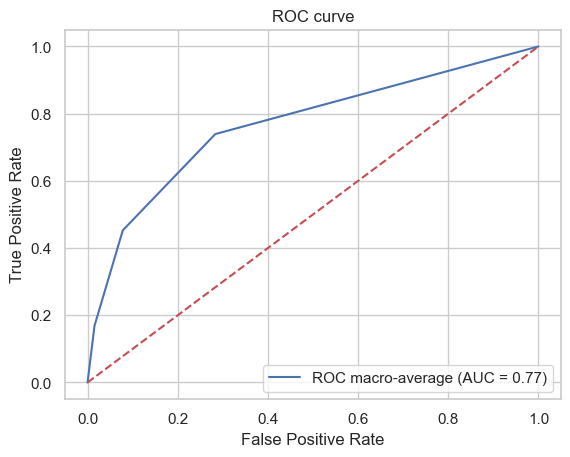

In [66]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 200, max_depth = 23, random_state=14)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', report)

saca_metricas(y_test, y_pred)

### 7.1 (Mod) Random Forest (100% training) - tuneo parámetros


Training dataset shape: (59400, 164) (59400,)


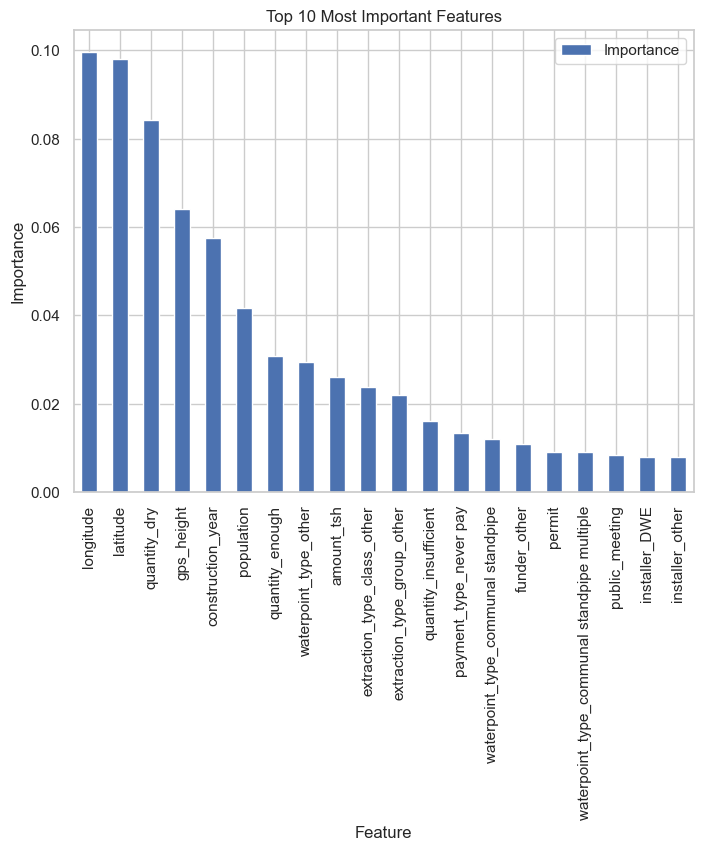

In [67]:
# Usar todo el dataset para entrenamiento
X_train_100 = df_final_OK.drop('status_group_map', axis=1)
y_train_100 = df_final_OK['status_group_map']

# X_train_100 = x_resampled
# y_train_100 = y_resampled


# Comprobamos dimensiones
print('Training dataset shape:', X_train_100.shape, y_train_100.shape)

# Initialize Random Forest Classifier
rf_100 = RandomForestClassifier(n_estimators = 200, max_depth = 23, random_state=14)

# Train the model
rf_100.fit(X_train_100, y_train_100)


# MOSTRAMOS IMPORTANCIAS
# Crear un DataFrame con las importancias de las características
feat_importances = pd.DataFrame(rf_100.feature_importances_, index=X_train_100.columns, columns=["Importance"])

# Ordenar las características por importancia
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Seleccionar las 10 primeras características más importantes
top_10_features = feat_importances.head(20)

# Graficar las 10 primeras características más importantes
top_10_features.plot(kind='bar', figsize=(8,6))
plt.title("Top 10 Most Important Features")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()


# 8. Predicción sobre los nuevos datos


Recuperamos nuestro dataframe únicamente con los nuevos datos a predecir tras su preprocesado completo.


In [68]:
# Realizamos el cruce con nuestro fichero origen "x_test_orig" (no nos traemos campos de este dataframe)
df_predict = pd.merge(df_final, x_test_orig.index.to_frame(), how='inner', left_index=True, right_index=True)

# Elimina la columna adicional 'id' creada por x_test_orig exclusivamente para el cruce
df_predict = df_predict[df_final.columns]

# Verificamos resultados (nos tiene que dar 14.850 registros)
display(df_predict.head())
df_predict.info()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,funder_0,funder_Danida,funder_Dhv,funder_District Council,funder_Dwe,funder_Dwsp,funder_Germany Republi,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Ministry Of Water,funder_Norad,funder_Private Individual,funder_Rwssp,funder_Tasaf,funder_Tcrs,funder_Unicef,funder_Water,funder_World Bank,funder_World Vision,funder_other,installer_0,installer_CES,installer_Central government,installer_Commu,installer_Community,installer_DANID,installer_DANIDA,installer_DWE,installer_District Council,installer_Government,installer_HESAWA,installer_Hesawa,installer_KKKT,installer_RWE,installer_TCRS,installer_other,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_other,lga_rural,lga_urban,scheme_management_Company,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn,extraction_type_group_wind-powered,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,1996.0,35.290799,-4.059696,321,True,True,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
51630,0.0,1569.0,36.656709,-3.309214,300,True,True,2000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

<class 'pandas.core.frame.DataFrame'>
Index: 14850 entries, 50785 to 68707
Columns: 164 entries, amount_tsh to waterpoint_type_other
dtypes: bool(2), float64(5), int32(156), int64(1)
memory usage: 9.7 MB


### 8.1. Predicción con Random Forest


In [ ]:
# 1. Realizamos las predicciones con nuestros. Obtendremos una matriz con el resultado numérico de la predicción.
y_pred = rf.predict(df_predict)

# 2. Creamos el dataframe de los resultados con el formato adecuado.
# Añadimos los id's y parametrizamos la variable objetivo correctamente.
y_results = pd.DataFrame({'id': df_predict.index, 'status_group_map': y_pred})

status_group_mapping = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}

y_results['status_group'] = y_results['status_group_map'].replace(status_group_mapping) # Reemplazar los valores en la columna 'status'
y_results = y_results.drop('status_group_map', axis=1)

# 3. Mostrar el DataFrame resultante
display(y_results.head())

# 4. Exportamos los resultados en un fichero CSV.
y_results.to_csv('test_set_labels_RandomForest.csv', index = False)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Resultado: 0,8125

![](Results/test_set_labels_RandomForest.png)


### 8.2. Predicción con Random Forest (100% training)


In [ ]:
# 1. Realizamos las predicciones con nuestros. Obtendremos una matriz con el resultado numérico de la predicción.
y_pred = rf_100.predict(df_predict)

# 2. Creamos el dataframe de los resultados con el formato adecuado.
# Añadimos los id's y parametrizamos la variable objetivo correctamente.
y_results = pd.DataFrame({'id': df_predict.index, 'status_group_map': y_pred})

status_group_mapping = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}

y_results['status_group'] = y_results['status_group_map'].replace(status_group_mapping) # Reemplazar los valores en la columna 'status'
y_results = y_results.drop('status_group_map', axis=1)

# 3. Mostrar el DataFrame resultante
display(y_results.head())

# 4. Exportamos los resultados en un fichero CSV.
y_results.to_csv('test_set_labels_RandomForest_100.csv', index = False)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Resultado: 0,8195

![](Results/test_set_labels_RandomForest_100.png)


### 8.2. Predicción con Decision Tree


In [ ]:
# 1. Realizamos las predicciones con nuestros. Obtendremos una matriz con el resultado numérico de la predicción.
y_pred = dt.predict(df_predict)

# 2. Creamos el dataframe de los resultados con el formato adecuado.
# Añadimos los id's y parametrizamos la variable objetivo correctamente.
y_results = pd.DataFrame({'id': df_predict.index, 'status_group_map': y_pred})

status_group_mapping = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}

y_results['status_group'] = y_results['status_group_map'].replace(status_group_mapping) # Reemplazar los valores en la columna 'status'
y_results = y_results.drop('status_group_map', axis=1)

# 3. Mostrar el DataFrame resultante
display(y_results.head())

# 4. Exportamos los resultados en un fichero CSV.
y_results.to_csv('test_set_labels_DecisionTree.csv', index = False)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Resultado: 0,7574

![](Results/test_set_labels_DecisionTree.png)


### 8.3. Predicción con XGBClassifier


In [ ]:
# 1. Realizamos las predicciones con nuestros. Obtendremos una matriz con el resultado numérico de la predicción.
y_pred = XGB.predict(df_predict)

# 2. Creamos el dataframe de los resultados con el formato adecuado.
# Añadimos los id's y parametrizamos la variable objetivo correctamente.
y_results = pd.DataFrame({'id': df_predict.index, 'status_group_map': y_pred})

status_group_mapping = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}

y_results['status_group'] = y_results['status_group_map'].replace(status_group_mapping) # Reemplazar los valores en la columna 'status'
y_results = y_results.drop('status_group_map', axis=1)

# 3. Mostrar el DataFrame resultante
display(y_results.head())

# 4. Exportamos los resultados en un fichero CSV.
y_results.to_csv('test_set_labels_XGBClassifier.csv', index = False)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


## Resultado: 0,7768

![](Results/test_set_labels_XGBClassifier.png)


## 9. RÉCORD FINAL

Finalmente, obtuvimos un resultado final de 0,8195 con el proceso detallado utilizando el modelo de Random Forest entrenado con la totalidad de datos de entrenamiento. Como ya podíamos suponer debido a los resultados que vinmos durante la evaluación de los modelos, Random Forest fue el que mejor comportamiento tuvo ante los nuevos datos.

¡Estamos en la posición 2.073!

![](Results/Record_Intento.png)


![](Record_final_04.png)
